
# Can you predict stock price movements using neural networks?
## a project by Alexander Michalik, Lukas Schneider, Sebastian Bielfeldt and Jesse Jones

## Table of Contents

- Objective
- Data Preparation
    - One-Hot Encoding
- Evaluation Functions
- Neural Network Models
    - Convolutional Neural Network
        - Convolutional Neural Network with OHE Industry Sector Input
    - Fully Connected Neural Network
    - Recurrent Neural Network with LSTM
        - Recurrent Neural Network with LSTM and OHE Industry Sector Input
    - Recurrent Neural Network with GRU
        - Recurrent Neural Network with GRU and OHE Industry Sector Input
- Discussion and Outlook
    

## Objective

- Predict seemingly random Stock Market Changes
- Try to find Underlying Patterns
- Evaluate Time Series as Prediction Factor
- Use known effect of Industry Correlation for Prediction

In [5]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
#import yfinance as yf
#import pandas_datareader as pdr
import csv
import warnings
from keras import layers
from keras import models
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

#hide all warnings
#warnings.filterwarnings('ignore')

#show all warnings just once
warnings.filterwarnings(action='once')

## Data and Preliminaries
- adjusted close values
- N = 20 stocks
- $t_{min} = 2007  \, ,\quad t_{max} = 2017$

- Input Data
    - Adjusted Close Values
    - Return Values
    - Implied Volatility Values

In [6]:
def data_loader(begin, finish, output_file): 
    data_r = pd.DataFrame()
    df_r = pd.DataFrame()
    returns_r = pd.DataFrame(columns=tickers)
    loaded_r = pd.DataFrame()
    df_l_r = []
    for ticker in tickers:
        loaded_r = yf.download(ticker, start=begin, end=finish).loc[:,['Adj Close']]
        df_r = loaded_r.pct_change(fill_method='ffill')
        df_l_r.append(df_r)
    df_r = pd.concat(df_l_r, axis=1)
    df_r.columns = tickers
    df_r.iloc[1:, :]
    df_r.to_csv(output_file)

In [7]:
def delete_nans(input_file, output_file):
    dirty_data = pd.read_csv(input_file, index_col='Date', parse_dates=['Date']).fillna(0)
    data = pd.DataFrame(dirty_data)
    data.to_csv(output_file)
    #saves csv like dataframe with header and index 
    
def get_returns(input_file, N):
    branches = pd.read_csv('snp500info.csv', index_col=0)
    returns = pd.read_csv(input_file, index_col='Date', parse_dates=['Date']).iloc[2:, :]
    branches = branches[branches.index.isin(list(returns))]
    returns = returns[list(branches.index)]
    returns = returns.T.sample(N).T
    D = returns.shape[0]
    #print('Number of columns with only NaNs: {}'.format(sum(returns.isna().sum(axis=0) == D)))
    #print('Number of lines with only NaNs: {}'.format(sum(returns.isna().sum(axis=1) == D)))
    print('Number of NaNs: {}'.format(returns.isna().sum().sum()))
    returns = pd.DataFrame.dropna(returns, axis='columns', how='all')
    print('shape Dataframe: {}'.format(returns.shape))
    return returns.fillna(value=0.)

In [8]:
def plot_example_returns1(input_file, number_stocks):
    data_use = pd.read_csv(input_file, index_col='Date', parse_dates=['Date']).iloc[:,:number_stocks]
    stock_list = data_use.columns
    if number_stocks <= 40:
        fig = plt.figure(figsize=(40,20))
        
        ax = fig.add_subplot(121)
        np.cumprod(1+data_use, axis=0).plot(ax=ax, title='stock price')
        np.cumprod(1+data_use.mean(axis=1)).plot(ax=ax, label='mean', color='black')
        ax.legend()
        
        ax = fig.add_subplot(122)
        data_use.plot(ax=ax, title='returns')
        ax.legend()
        plt.show()
        
def data_head(input_file, number_stocks):
    data_use = pd.read_csv(input_file, index_col='Date', parse_dates=['Date']).iloc[:,:number_stocks]
    display(data_use.head())

In [9]:
begin = "2007-01-01"
finish = "2017-01-01"
N=20

#data_loader(begin, finish, 'returns.csv')
returns = get_returns('returns.csv', N)
delete_nans('returns.csv', 'returns.csv')
data_head('returns.csv', N)

Number of NaNs: 0
shape Dataframe: (2518, 20)


MMM       ABT  ABBV      ABMD       ACN      ATVI      ADBE  \
Date                                                                           
2007-01-03  0.000000  0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
2007-01-04 -0.003961  0.018991   0.0  0.021352  0.022540  0.008158  0.022545   
2007-01-05 -0.006799  0.000000   0.0 -0.014634 -0.013979 -0.005780 -0.004900   
2007-01-08  0.002195  0.003607   0.0 -0.002122  0.014449 -0.000581 -0.004185   
2007-01-09  0.001160  0.008786   0.0 -0.010631 -0.002419 -0.000582 -0.020272   

                 AMD       AAP       AES       AMG       AFL         A  \
Date                                                                     
2007-01-03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2007-01-04  0.013832  0.006464  0.000456 -0.010861 -0.011027  0.003207   
2007-01-05 -0.004043 -0.022061 -0.028702 -0.008021  0.001312 -0.009299   
2007-01-08 -0.012177  0.003427 -0.014071  0.013187  0.000655 -0.003520   
2007-01-09  0.009245  0.008537 -0.040914  0.009690  0.003709  0.001178   

                 APD      AKAM       ALK       ALB       ARE      ALXN  \
Date                                                                     
2007-01-03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2007-01-04 -0.021972  0.023622  0.019508 -0.004584 -0.001686  0.002955   
2007-01-05 -0.013934 -0.002064 -0.036116 -0.017446 -0.019664 -0.006629   
2007-01-08 -0.001298 -0.003384  0.021092 -0.005114 -0.009523 -0.027435   
2007-01-09 -0.002166 -0.006414  0.008263  0.005854  0.024956 -0.007624   

                ALGN  
Date                  
2007-01-03  0.000000  
2007-01-04  0.018727  
2007-01-05  0.002941  
2007-01-08  0.002933  
2007-01-09  0.001462

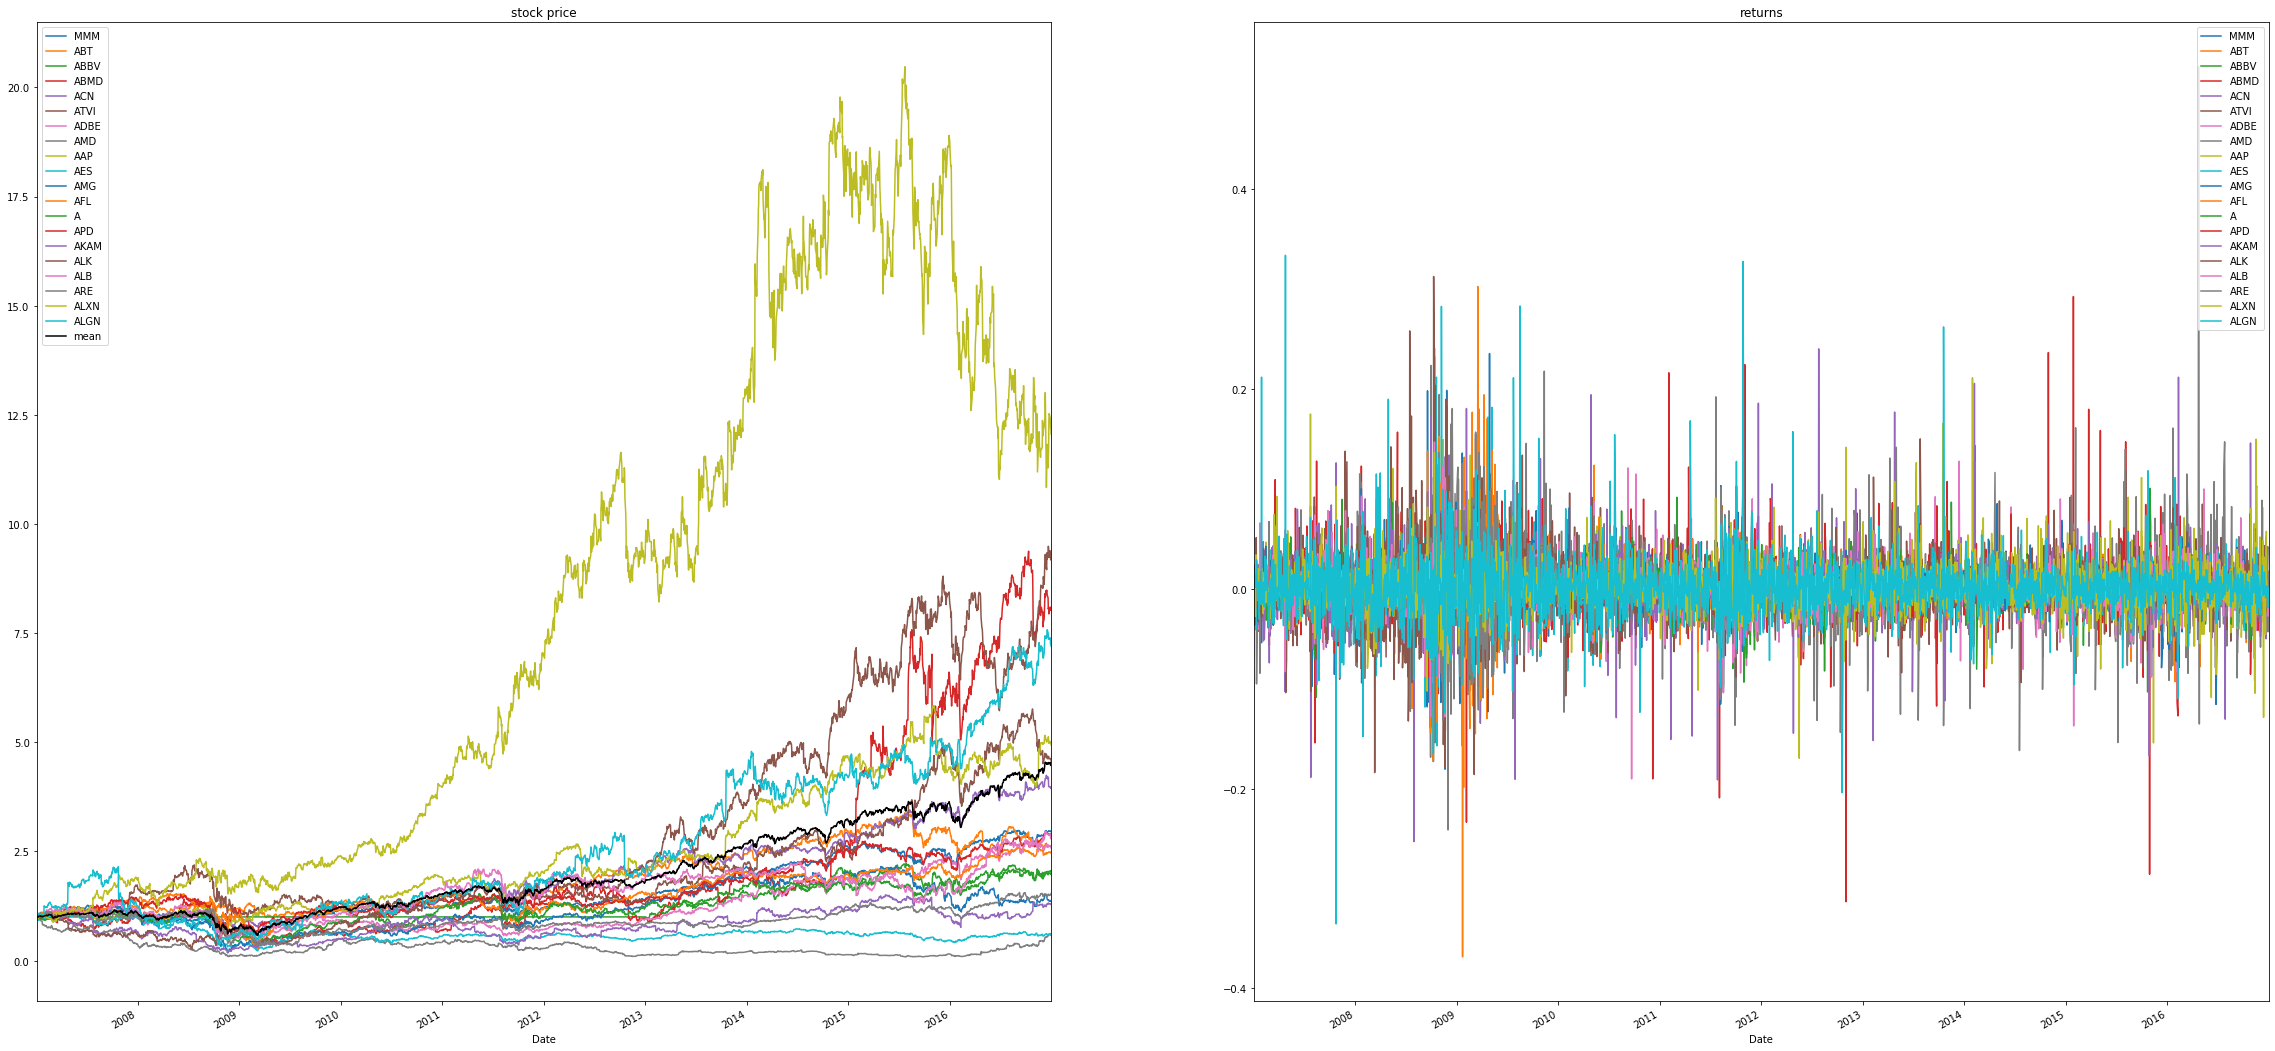

In [9]:
plot_example_returns1('returns.csv', N)

In [66]:
def get_data_subsets(df, dur, variant, onehot):
    """ 
    variant options: month, vola, next_day
    """
    
    branches_ = pd.read_csv('snp500info.csv', index_col=0)
    branches = branches_.drop(columns = ['Security', 'GICS Sub Industry', 'start at yahoo'])

    companies = list(df)
    data_onehot = branches.loc[branches.index.isin(companies)].iloc[:,0]
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(data_onehot)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded).T

    df = np.array(df)
    month = 30
    leng = df.shape[0]
    x=[]
    y=[]
    for i in range(leng):
        if dur+i>=leng:
            break
        if onehot:
            x_inp = np.concatenate((onehot_encoded, df[i:dur+i,:]))
        else:
            x_inp = df[i:dur+i,:]
            
        if variant == 'vola':
            x.append(np.abs(x_inp))
            y.append(np.abs(df[dur+i,:]))
        else:
            x.append(x_inp)
            if variant == 'month':
                y.append(np.mean(df[dur+i:dur+i+month,:], axis = 0))
            elif variant == 'next_day':
                y.append(df[dur+i,:])
            else:
                raise NameError("Use correct fun_label")
    return np.array(x),np.array(y)

### One Hot Encoding of Branch Information

In [11]:
pd.read_csv('snp500info.csv', index_col=0).head()
branches_ = pd.read_csv('snp500info.csv', index_col=0)
branches = branches_.drop(columns = ['Security', 'GICS Sub Industry', 'start at yahoo'])
branches.head()

GICS Sector
Ticker symbol                        
MMM                       Industrials
ABT                       Health Care
ABBV                      Health Care
ACN            Information Technology
ATVI           Information Technology

In [67]:
data = branches.iloc[:,0]
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data)
print(integer_encoded)

[ 5  4  4  6  6  5  6  6  0 10  4  3  3  4  7  6  5  7  8  4  4  5  4  6
 10  3  6  6  1  0 10  5 10  3  3  8 10  3  4  5  4  6  2  6  2  6  4  3
  5  2  8  6  6  1  5  3  3  9  6  6  0  8  7  2  7  3  3  4  4  3  4  3
  0  4  3  3  5  0  8  4  3  4  6  1  5  6  2  6  1  3  4  3  0  0  5  8
  0  4  4 10  9  4  7  3  0  2  2  0  3  1  4  2  3  5  6  3  3  6  1  3
 10  1  6  1  0  3  1  2  2 10  1  4  6  1  1  8  6  5  5  1  0  4  0  4
  5  0  5  4  2  8  3  0  0  0  0  0 10  5  7  1 10  8 10  6  3  7  5  6
  7 10  4  6  5 10  4  2  2  5  8  8  8  1 10  3 10  0  5  4  8  2  6  6
  5  8  5  6  3 10  6  6  5  5  7  0  0  5  5  3  7  0  0  6  5  5  8  1
  0  0  4  6  3  0  5  2  0  0  6  3  0  4  8  2  4  1  2  6  0  4  0  5
  1  8  6  4  3  4  5  5  4  5  6  3  6  4  7  0  7  6  4  3  4  8  5  5
  1  4  5  3  6  5  1  3  1  8  2  6  0  1  1  0  5  4  6  0  0  3  4  3
  0  5  3  0  7  3  8  0  2  2  0  3  7  5  6  0  1  0  4  4  4  3  4  0
  0  6  6  6  8  0  1  1  7  1  3  3  7  6  4  3  2

In [69]:
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
df = pd.DataFrame(onehot_encoded)
df.head()

0    1    2    3    4    5    6    7    8    9   10
0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0

## Evaluation Functions

Evaluation Types:
- Sign test
- Predicition vs Result
- Simultaneous Plot over Time
- Top 5 Portfolio Test

### Sign Test
 - Compares Signs of Model Prediction and Data
 - Absolute Test of Prediction Quality

In [13]:
def directional_goodness(model,x_test,y_test):
    """
    directional goodnes gives the factor of correctly predicted signs of first order derivative of returns to false ones
    oder auch: 
    gibt die Anzahl der Beobachtungen an, deren Vorhersage das richtige Vorzeichen hatte (Kurs steigt, Kurs fällt)
    """

    try:
        y_pred = model.predict(x_test)
    except AttributeError:
        y_pred = model(x_test)
    count = 0
    #print(y_new.shape)
    for i in range(len(y_pred)):
        for j in range(len(y_pred[i])):
            p= y_pred[i,j] > 0
            n = y_test[i,j] > 0
            if n==p:
                count +=1
    print('percentage of correctly predicted directions of returns: ' + str(count/len(y_pred)/len(y_pred[0])))

### Top 5 Portfolio Test

- Select 5 stocks with highest expected portfolio
- Calculate Mean Return of top 5 stocks
- Compare with Mean Return of all Stocks
- Relative Test of prediction quality

In [ ]:
def largest(array, amount):
    return array.argsort()[:,-amount:]


def compare_top(model, x_test, y_test):
    try:
        y_pred = model.predict(x_test)
    except AttributeError:
        y_pred = model(x_test)
    amount = 5
    mean_all = np.mean(y_test)
    
    top_index = largest(y_pred,amount)
    mean_mach = np.mean(y_test[top_index])
    ret = mean_mach-mean_all
    print('Difference between mean return and return of calculated top 5: ' + str(ret))
    return ret

### Prediction vs Result

- Scatter Plot Prediction/Result
- Visualize the Data

In [15]:
def internal_goodness(model, x_new, y_new):
    print('compare true to predicted values of internal validation on learned dataset: ')
    y_pred = model.predict(x_new)
    #model.predict nimmt x-werte und gibt die predicteten y-werte zurück
    plt.scatter(y_new, y_pred)
    


### Simultaneous Plot over Time

- Plot both expected Returns and Actual Returns over time
- Visualize the Data

In [16]:
def external_goodness(model, x_new, y_new):
    print('compare true to predicted values of external validation set: ')
    y_pred = model.predict(x_new)
    color =  ["r", "b", "g"]
    for i in range(3):
        plt.plot(y_new[:20,i],c=color[i], label = 'true')
        plt.plot(y_pred[:20,i], c=color[i], linestyle='--', label = 'pred')
    plt.legend()

In [17]:
def plots(model, x_test, x_train, y_test, y_train):
    try:
        y_pred_test = model.predict(x_test)
        y_pred_train = model.predict(x_train)
    except AttributeError:
        y_pred_test = model(x_test)
        y_pred_train = model(x_train)
    else:
        pass
    print(np.array(y_pred_test).shape)
    color =  ["r", "b", "g"]
    plt.rcParams.update({'font.size': 23})
    
    fig = plt.figure(figsize = (40,20))
    
    ax2 = fig.add_subplot(222)
    ax2.scatter(y_test, y_pred_test)
    ax2.title.set_text('Pred vs Res of Test')
    ax2.set_xlim(-0.2, 0.2)
    ax2.set_ylim(-0.2, 0.2)
    
    ax4 = fig.add_subplot(224)   
    for i in range(3):
        plt.plot(y_test[:20,i],c=color[i], label = 'true')
        plt.plot(y_pred_test[:20,i], c=color[i], linestyle='--', label = 'pred')
    ax4.title.set_text('Simul Plot of Test')
    
    ax1 = fig.add_subplot(221)
    ax1.scatter(y_train, y_pred_train)
    ax1.title.set_text('Pred vs Res of Train')
    ax1.set_xlim(-0.2, 0.2)
    ax1.set_ylim(-0.2, 0.2)
    
    ax3 = fig.add_subplot(223)
    for i in range(3):
        plt.plot(y_train[:20,i],c=color[i], label = 'true')
        plt.plot(y_pred_train[:20,i], c=color[i], linestyle='--', label = 'pred')
    ax3.title.set_text('Simul Plot of Train')
    leg_elem =[]
    line = mpl.lines.Line2D([0], [0], c='grey', linestyle="-",
                                    label="true")
    leg_elem.append(line)
    line = mpl.lines.Line2D([0], [0], c='grey', linestyle="--",
                                    label="Prediction")
    leg_elem.append(line)
    
    ax3.legend(fontsize='small', handles=leg_elem)
    ax4.legend(fontsize='small', handles=leg_elem)

## Models

- Moving Average
- 1D CNN
- RNN
    - LSTM
    - GRU
- Fully Connected Network

### Moving Average

#### advantages:
- very simple to create
- computationally simple

#### disadvantages:
- can only "learn" overall trend
- unable to recognize short-term patterns

In [32]:
# Mean über alle returns, mean über ausgewählte Daten
print(np.mean(returns))
print("overall mean = " + str(np.mean(np.mean(returns))))

ULTA     0.001335
DXC      0.000730
DAL      0.001001
DRI      0.000659
SLG      0.000606
BBY      0.000373
BK       0.000486
BRK-B    0.000431
AVB      0.000554
NKE      0.000910
ADSK     0.000534
RTN      0.000613
FMC      0.000782
JBHT     0.000818
DRE      0.000619
LNC      0.000934
CNC      0.000951
SO       0.000363
AAPL     0.001145
DUK      0.000318
dtype: float64
overall mean = 0.0007081371508298192


In [18]:
def mov_avg(x_train):
    print(np.array(x_train).shape)
    return np.sum(x_train, axis = 1)/x_train.shape[1]

(518, 100, 20)
percentage of correctly predicted directions of returns: 0.5034749034749034
(518, 100, 20)
Difference between mean return and return of calculated top 5: -0.0006040408680788717
(518, 100, 20)
(1900, 100, 20)
(518, 20)


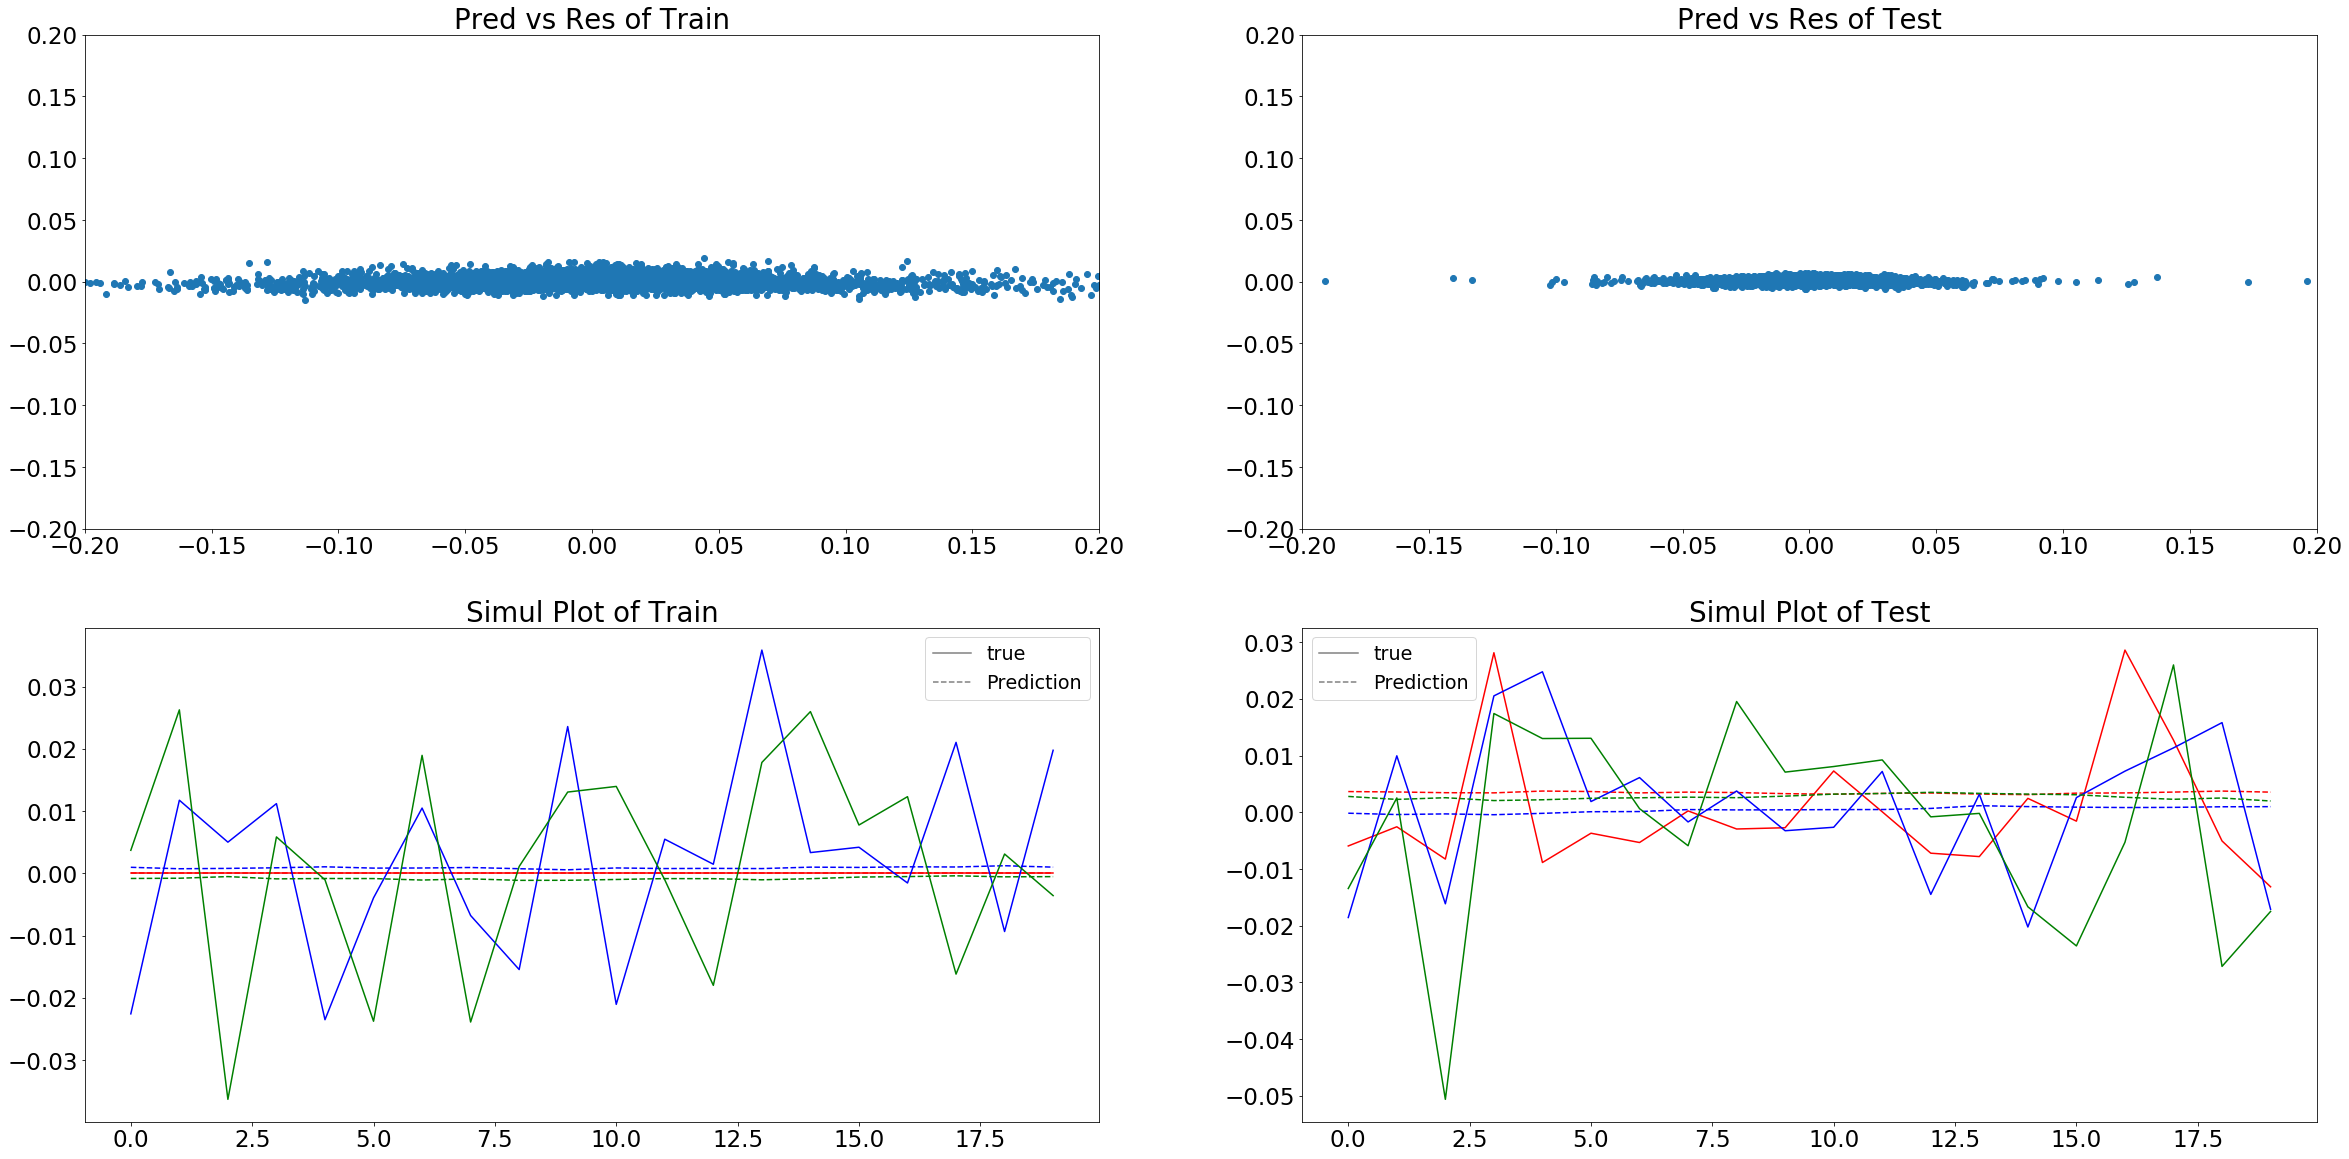

In [28]:
directional_goodness(mov_avg, x_test, y_test)
compare_top(mov_avg, x_test, y_test)
plots(mov_avg, x_test=x_test, x_train=x_train, y_test=y_test, y_train=y_train)

#### Expectations:
- moving average encodes information about overall trend
- does not work well for short time series

#### Results:
- returned $\approx$ 0

### Convolutional Neural Network

#### advantages:
- recognizes short-term patterns
- less susceptible to overfitting

#### disadvantages:
- if no patterns found computationally more complex than necessary
- if no patterns found 

In [24]:
def cnn(x_train, y_train, x_test, y_test, inp_shape):
    verbose, epochs, batch_size = 0, 200, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    N = inp_shape[1]
    #init
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu',
                     input_shape=inp_shape))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    #Conv1D => 1D Convolution (Schaut nach Mustern)
    #mit filters = Anzahl Weight Functions, kernel_size = Anzahl simultan betrachteter Felder, 
    #relu = 0 für value<0 sonst linear
    
    model.add(layers.Dropout(0.3))
    #Dropout sets randomly chosen values to 0 to prevent overfitting
    
    model.add(layers.MaxPooling1D(pool_size=2))
    #MaxPooling halbiert array Größe und nimmt größte Werte der Feature-Gewichtungen 
    
    model.add(layers.Flatten())
    #Flatten reduziert dimensionen eines arrays auf niedrigst mögliche Dimension (1xdim) (überschreibt Nullen))
    
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(N, activation='linear'))
    #Klassisches NN hinter Convolutional Layer geschaltet, lernt also im Feature Raum, durch Convolutional Net vorgebenen
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(x_train,y_train, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(x_test,y_test, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model

In [25]:
def main_cnn(input_df, dur, limit, variant):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    variant     prediction of next day, next month average, volatility
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur, variant="next_day", onehot=0) 
    x_test,y_test = get_data_subsets(test, dur, variant="next_day", onehot=0)
    inp_shape = (dur,N)
    
    x_train = x_train[:,x_train.shape[1]-dur:,:]
    x_test = x_test[:,x_test.shape[1]-dur:,:]
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train.shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test.shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = cnn(x_train, y_train, x_test, y_test, inp_shape)
    return model,x_train,y_train,x_test,y_test

#### Next Day

In [26]:
model_cnn,x_train,y_train,x_test,y_test = main_cnn(returns, 100, 2000, variant='next_day')
print(model_cnn.summary())

x-train shape: (1900, 100, 20)
y-train shape: (1900, 20)
x-test shape: (518, 100, 20)
y-test shape: (518, 20)
test shape: (618, 20)
0.0003173256672300312
0.00031732567003928125
0.01236127968877554
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 98, 64)            3904      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 64)            12352     
_________________________________________________________________
dropout_2 (Dropout)          (None, 96, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 48, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_______________________________________________________

percentage of correctly predicted directions of returns: 0.5015444015444015
Difference between mean return and return of calculated top 5: 0.00031173321773021246
(518, 20)


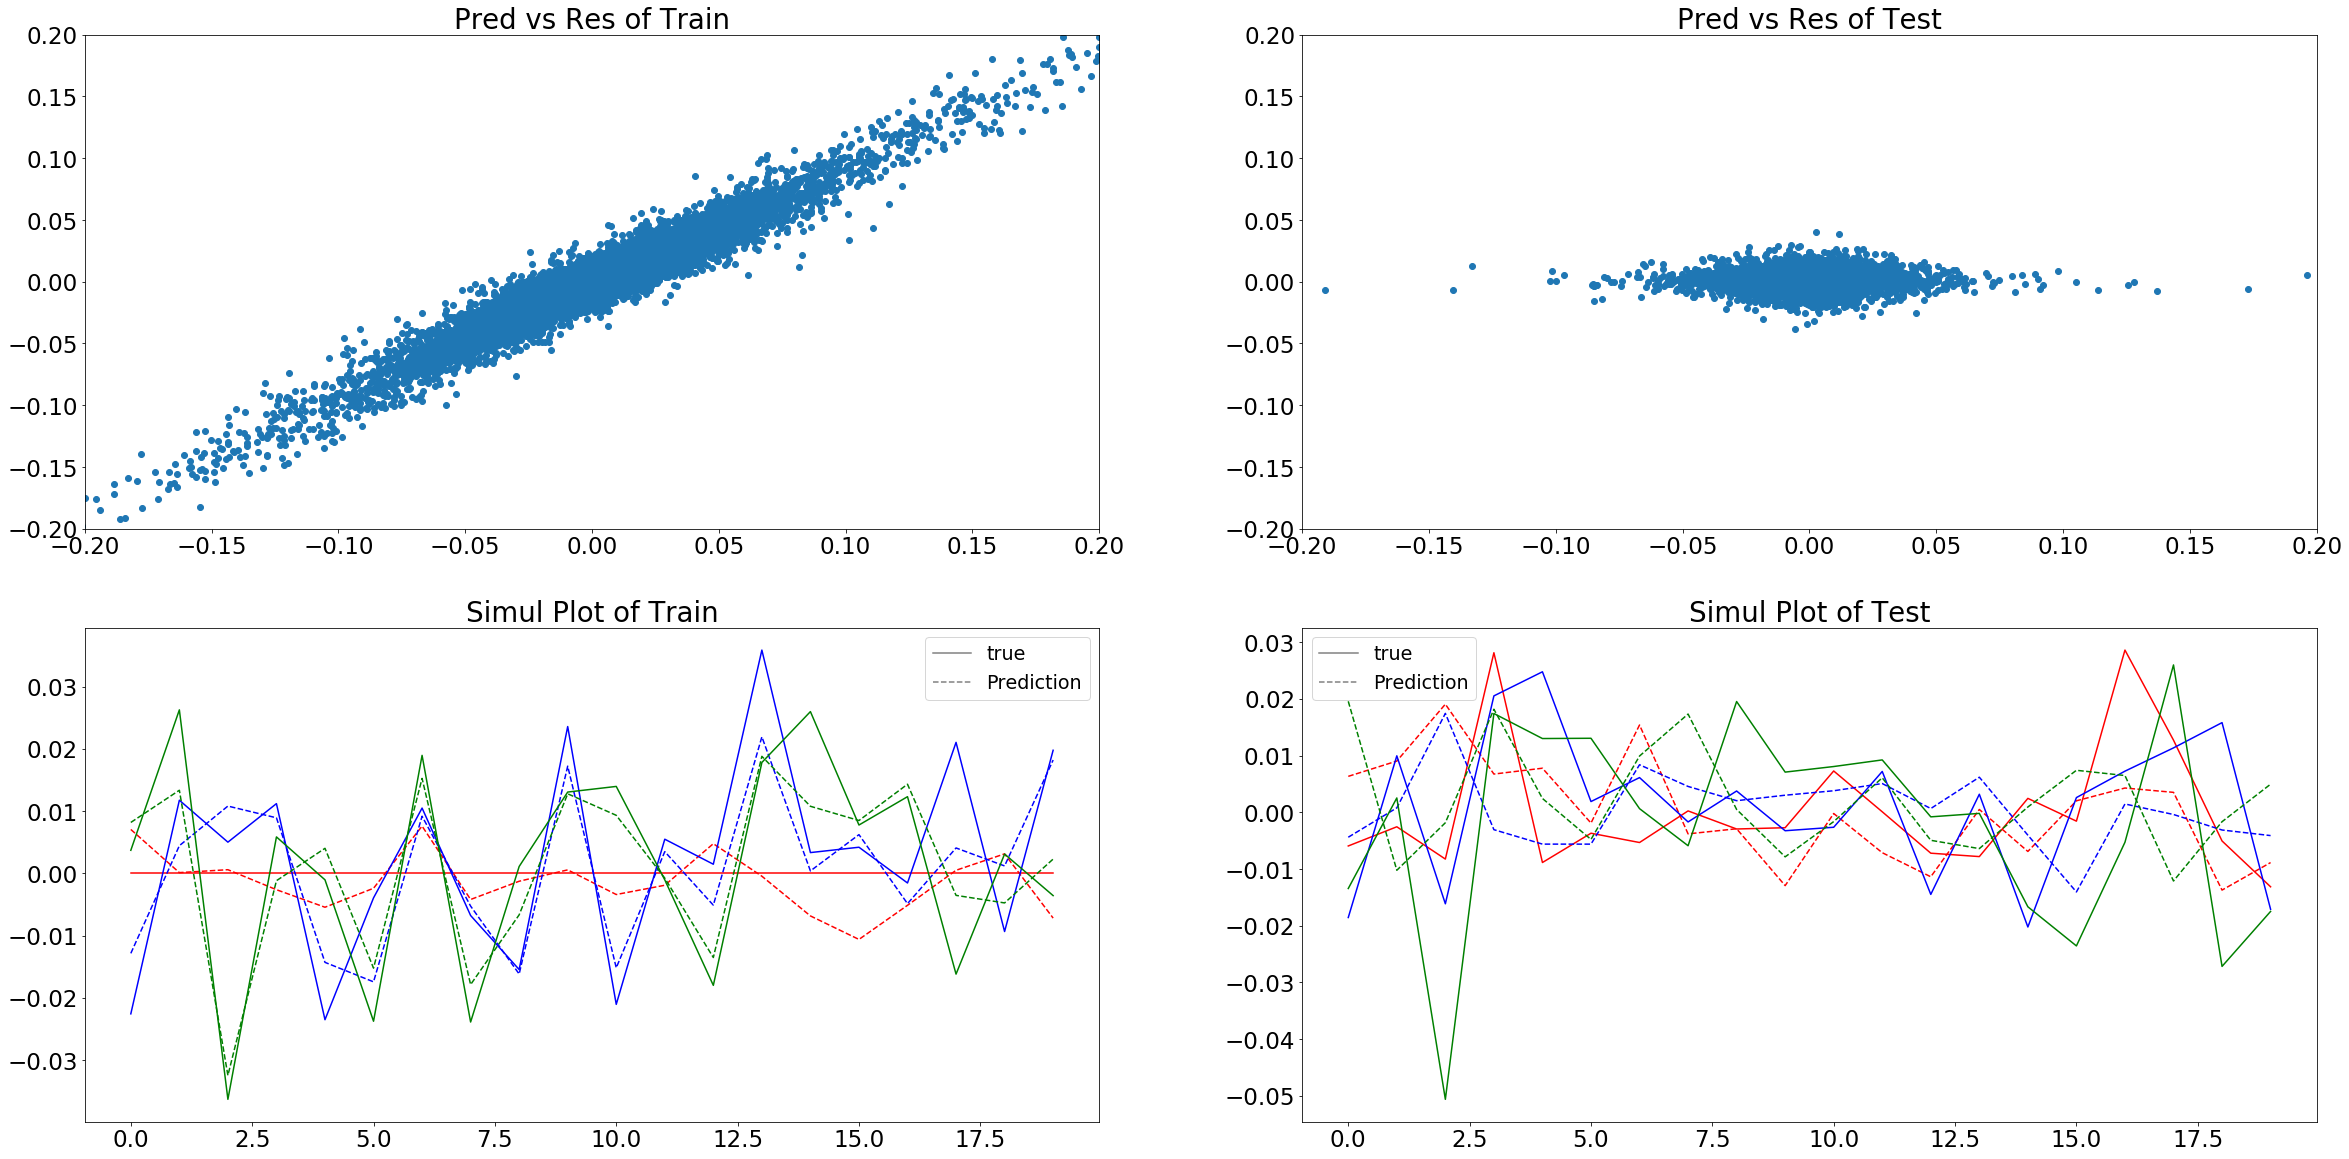

In [27]:
directional_goodness(model_cnn, x_test, y_test)
compare_top(model_cnn, x_test, y_test)
plots(model_cnn, x_test=x_test, x_train=x_train, y_test=y_test, y_train=y_train)

#### Next Month Average

In [63]:
model_cnn,x_train_m,y_train_m,x_test_m,y_test_m = main_cnn(returns, 100, 2000, variant='month')
print(model_cnn.summary())

x-train shape: (1900, 100, 20)
y-train shape: (1900, 20)
x-test shape: (518, 100, 20)
y-test shape: (518, 20)
test shape: (618, 20)
0.00031587725088789585
0.000315877259708941
0.01229932066053152
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 98, 64)            3904      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 96, 64)            12352     
_________________________________________________________________
dropout_10 (Dropout)         (None, 96, 64)            0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 48, 64)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 3072)              0         
________________________________________________________

percentage of correctly predicted directions of returns: 0.5077220077220077
Difference between mean return and return of calculated top 5: 0.0002689281915605312
(518, 20)


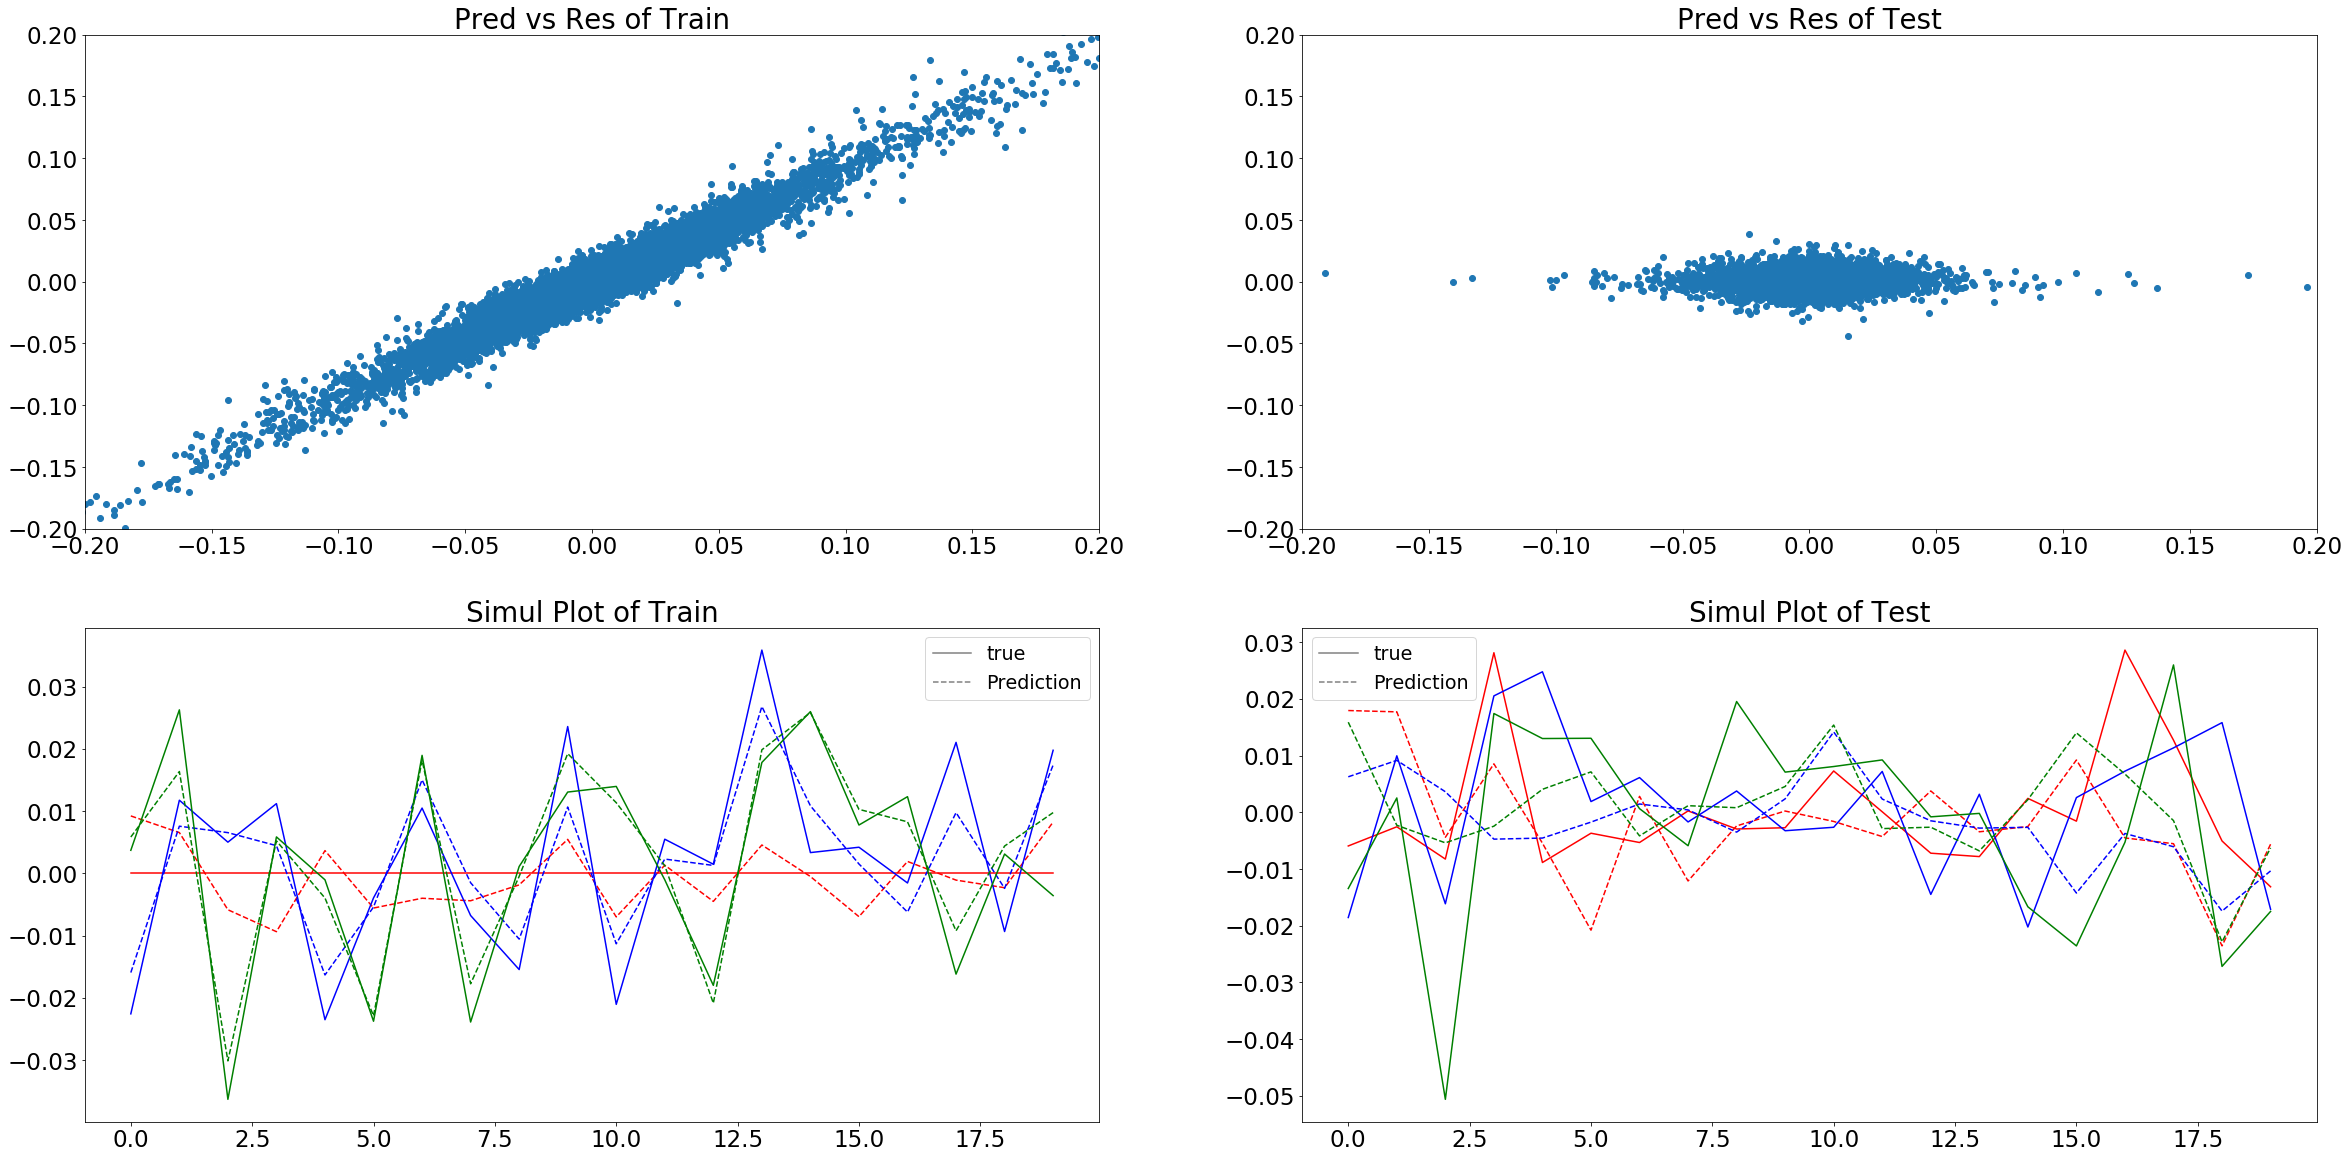

In [64]:
directional_goodness(model_cnn, x_test_m, y_test_m)
compare_top(model_cnn, x_test_m, y_test_m)
plots(model_cnn, x_test=x_test_m, x_train=x_train_m, y_test=y_test_m, y_train=y_train_m)

#### Implied Volatility

In [61]:
model_cnn,x_train_v,y_train_v,x_test_v,y_test_v = main_cnn(returns, 100, 2000, variant='vola')
print(model_cnn.summary())

x-train shape: (1900, 100, 20)
y-train shape: (1900, 20)
x-test shape: (518, 100, 20)
y-test shape: (518, 20)
test shape: (618, 20)
0.00032431849834291645
0.0003243184764869511
0.012600344605743885
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 98, 64)            3904      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 96, 64)            12352     
_________________________________________________________________
dropout_9 (Dropout)          (None, 96, 64)            0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 48, 64)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 3072)              0         
______________________________________________________

percentage of correctly predicted directions of returns: 0.49305019305019304
Difference between mean return and return of calculated top 5: 0.0012266113159684604
(518, 20)


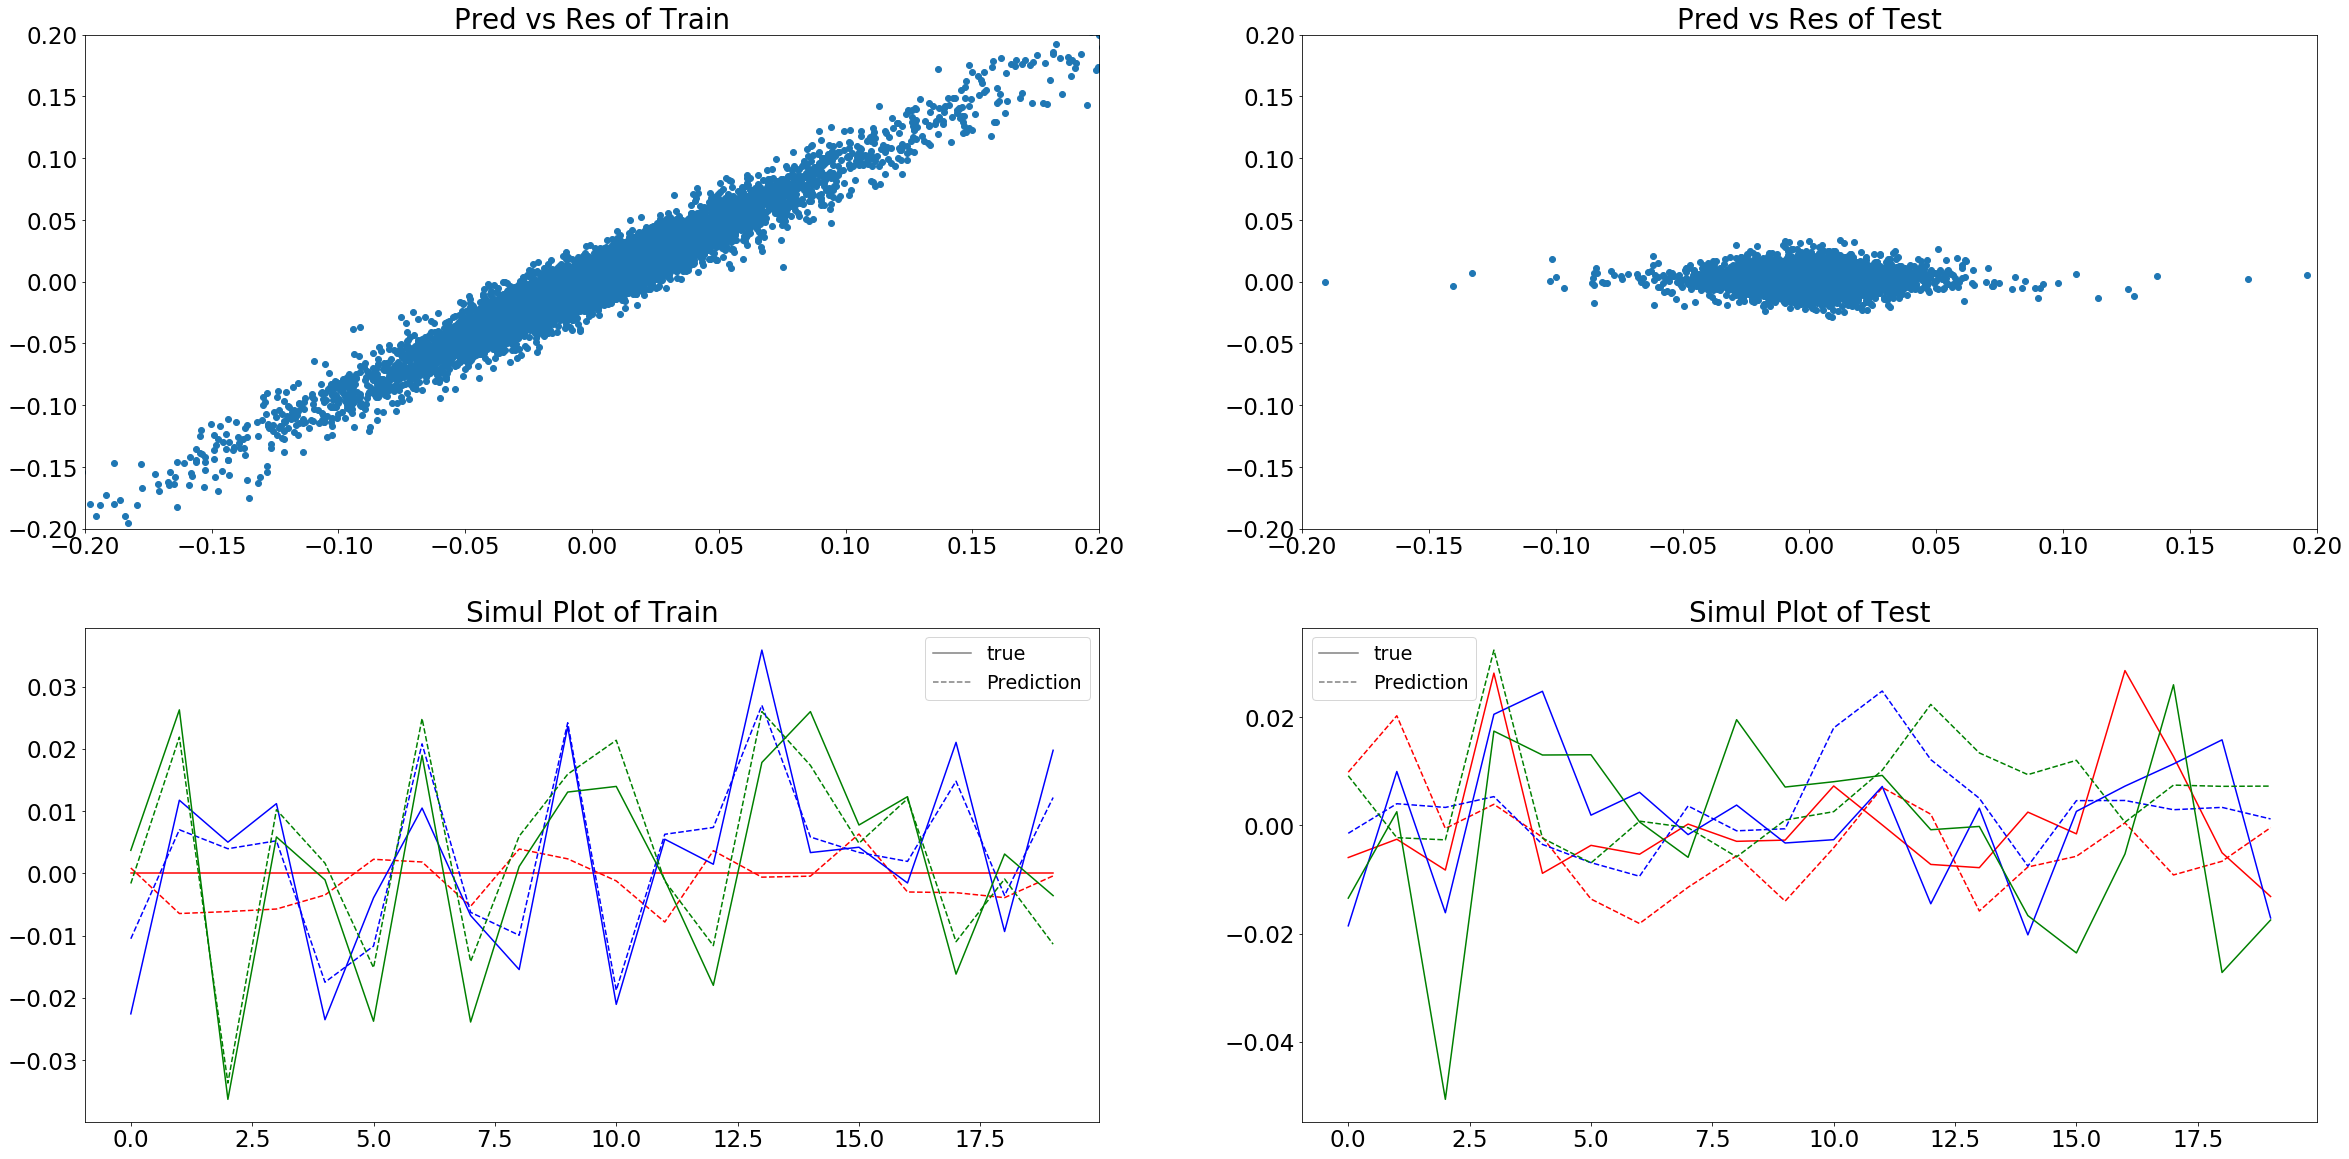

In [62]:
directional_goodness(model_cnn, x_test_v, y_test_v)
compare_top(model_cnn, x_test_v, y_test_v)
plots(model_cnn, x_test=x_test_v, x_train=x_train_v, y_test=y_test_v, y_train=y_train_v)

Expectations:
- CNN learns patterns in stock market changes, if there are any recognisable patterns
- Patterns lead to better predictions

Results:
- No Patterns were recognised, or influence of recognised patterns was diminishing/not contributing to better predictions
- Prediction of Next Month Average (...)
- Prediction in Volatility Space (...)

### One-Hot Encoded Branch Info Convolutional Neural Network

#### advantages:
- network should have easier job learning known correlations inside industries

#### disadvantages: 
- more complicated data structure
- need to build sequential network
    - one for adjusted close
    - one for branch info

In [33]:
def cnn_2inputs(xtrain,ytrain,xtest,ytest,inp_shape1,inp_shape2):
    verbose, epochs, batch_size = 0,200, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    i1 = layers.Input(inp_shape1)
    i2 = layers.Input(inp_shape2)
    
    N = inp_shape1[1]
    #init
    model1 = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(i1)
    model1 = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(model1)
    #Conv1D => 1D Convolution (Schaut nach Mustern)
    #mit filters = Anzahl Weight Functions, kernel_size = Anzahl simultan betrachteter Felder, 
    #relu = 0 für value<0 sonst linear
    
    model1 = layers.Dropout(0.5)(model1)
    #Dropout sets randomly chosen values to 0 to prevent overfitting
    
    model1 = layers.MaxPooling1D(pool_size=2)(model1)
    #MaxPooling halbiert array Größe und nimmt größte Werte der Feature-Gewichtungen 
    
    model1 = layers.Flatten()(model1)
    #Flatten reduziert dimensionen eines arrays auf niedrigst mögliche Dimension (1xdim) (überschreibt Nullen))
    model1 = models.Model(inputs = i1, outputs = model1)
    
        ### second network:
    model2 = layers.Flatten()(i2)
    model2 = layers.Dense(100, activation="relu")(model2)
    #model2 = layers.Dense(100, activation="relu")(model2)
    model2 = models.Model(inputs = i2, outputs = model2)
    
    combined = layers.concatenate([model1.output, model2.output])
    
    
    model = layers.Dense(100, activation='relu')(combined)
    model = layers.Dense(N, activation='linear')(model)
    model = models.Model(inputs = [model1.input, model2.input], outputs = model)
    #Klassisches NN hinter Convolutional Layer geschaltet, lernt also im Feature Raum, durch Convolutional Net vorgebenen
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(xtrain,ytrain, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(xtest,ytest, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model

In [34]:
def main_cnn_2inputs(input_df, dur, limit, variant):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    variant     prediction of next day, next month average, volatility
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur, variant, onehot=1) 
    x_test,y_test = get_data_subsets(test, dur, variant, onehot=1)
    inp_shape1 = (dur,N)
    inp_shape2 = (x_train.shape[1]-dur,N)
    x_train = [x_train[:,inp_shape2[0]:,:],x_train[:,:inp_shape2[0],:]]
    x_test = [x_test[:,inp_shape2[0]:,:],x_test[:,:inp_shape2[0],:]]
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train[0].shape)+ str(x_train[1].shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test[0].shape)+ str(x_test[1].shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = cnn_2inputs(x_train, y_train, x_test, y_test, inp_shape1,inp_shape2)
    return model,x_train,y_train,x_test,y_test

#### Next Day

In [70]:
model_cnn_2inputs,x_train,y_train,x_test,y_test = main_cnn_2inputs(returns, 100, 2000, variant='next_day')
print(model_cnn_2inputs.summary())

x-train shape: (1900, 100, 20)(1900, 8, 20)
y-train shape: (1900, 20)
x-test shape: (518, 100, 20)(518, 8, 20)
y-test shape: (518, 20)
test shape: (618, 20)
0.0003052462038110302
0.00030524624162353575
0.012067082338035107
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 100, 20)      0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 98, 64)       3904        input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 96, 64)       12352       conv1d_13[0][0]                  
__________________________________________________________________

percentage of correctly predicted directions of returns: 0.4953667953667954
Difference between mean return and return of calculated top 5: -0.0005297879065463008
(518, 20)


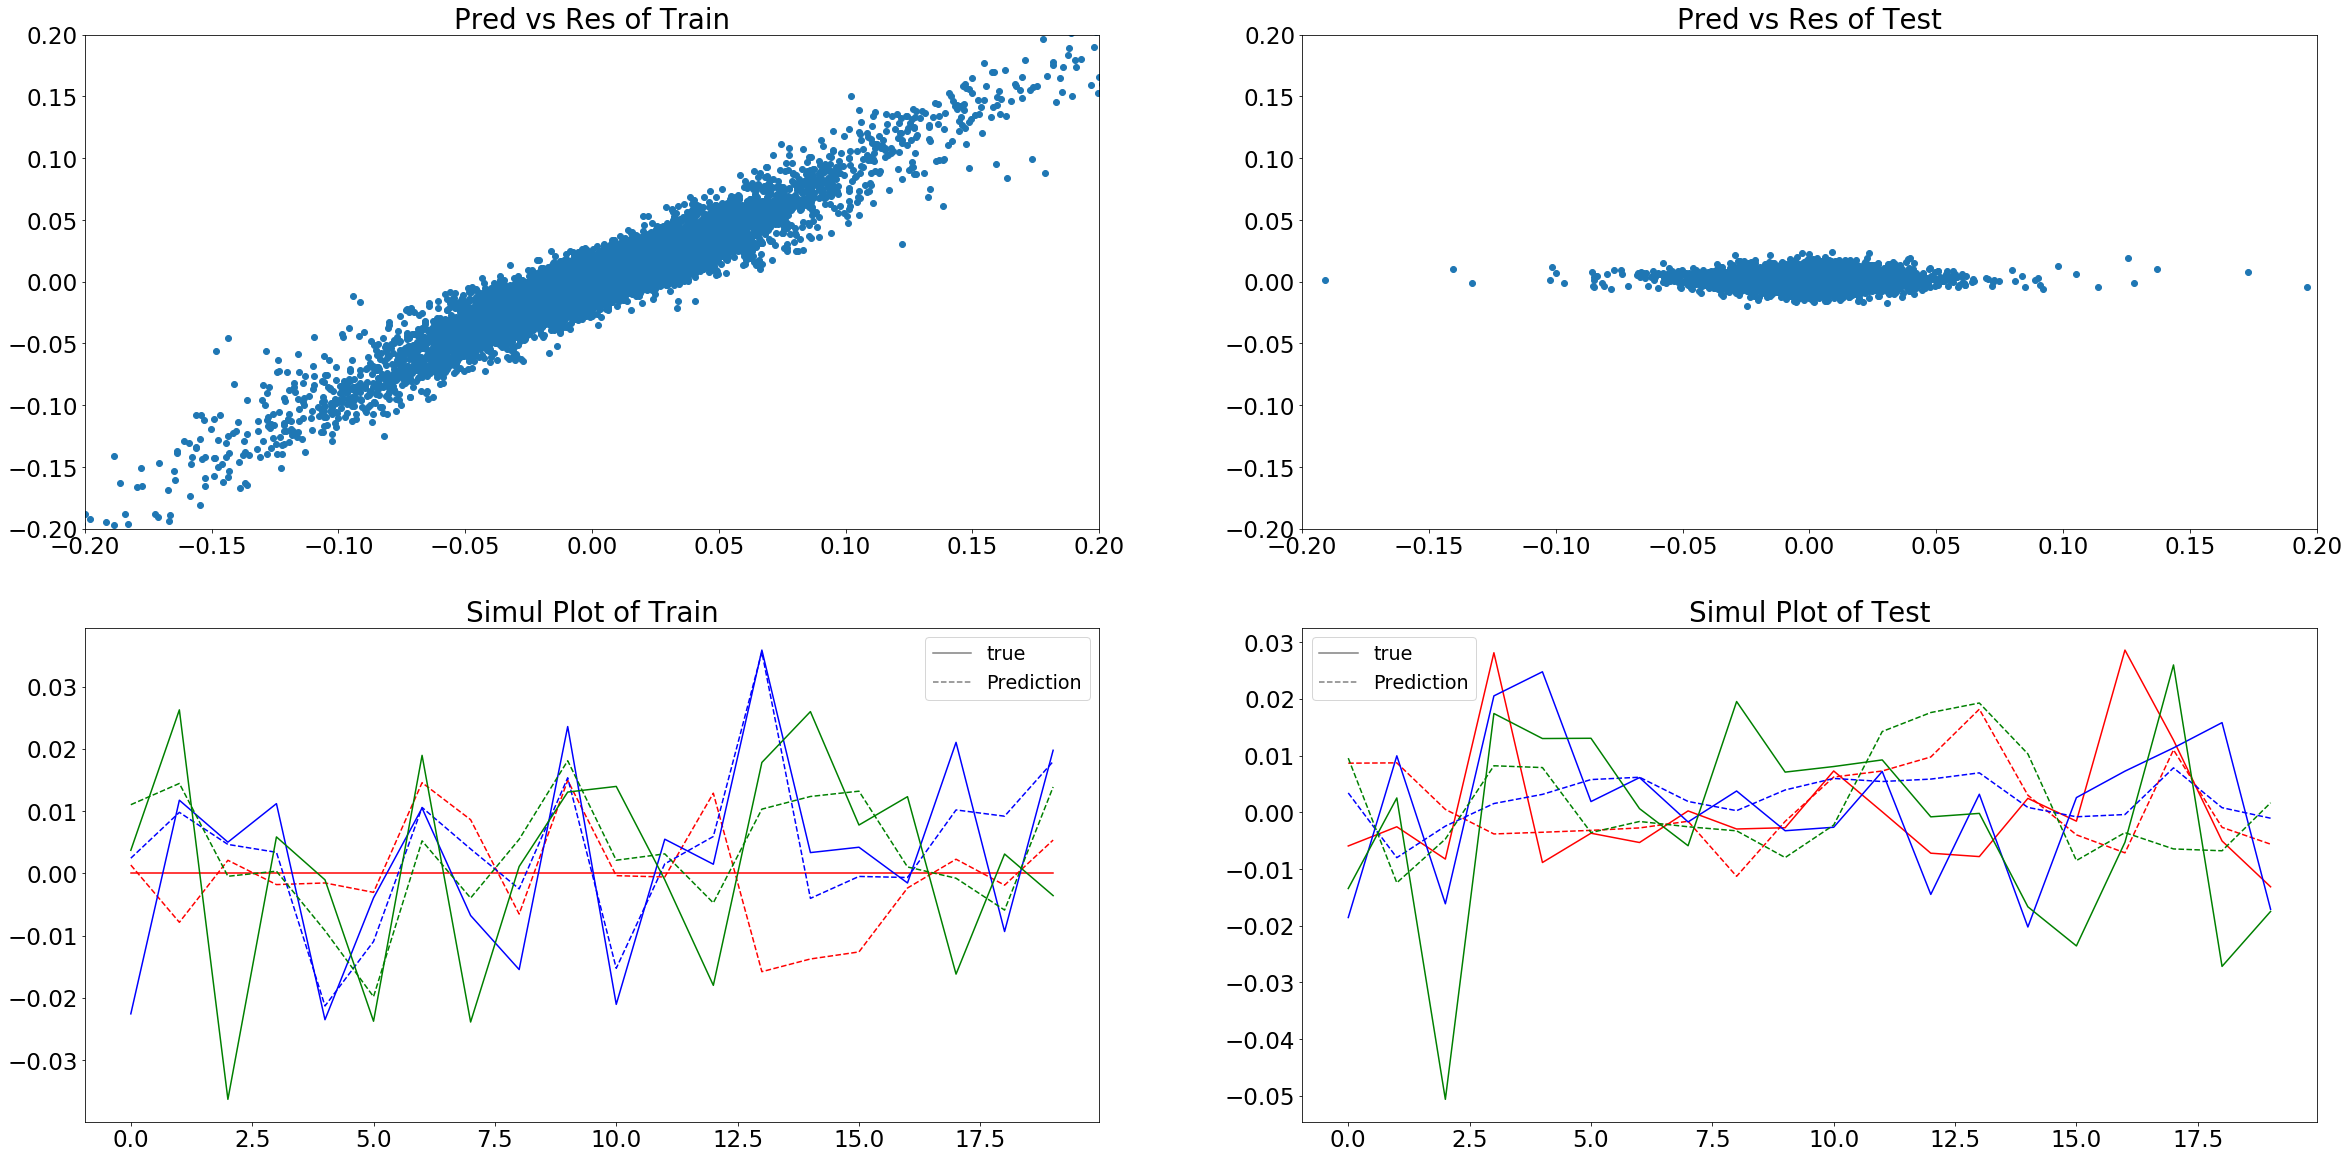

In [71]:
directional_goodness(model_cnn_2inputs, x_test, y_test)
compare_top(model_cnn_2inputs, x_test, y_test)
plots(model_cnn_2inputs, x_test=x_test, x_train=x_train, y_test=y_test, y_train=y_train)

#### Next Month Average

In [72]:
model_cnn_2inputs,x_train_m,y_train_m,x_test_m,y_test_m = main_cnn_2inputs(returns, 100, 2000, variant='month')
print(model_cnn_2inputs.summary())

x-train shape: (1900, 100, 20)(1900, 8, 20)
y-train shape: (1900, 20)
x-test shape: (518, 100, 20)(518, 8, 20)
y-test shape: (518, 20)
test shape: (618, 20)
1.1435595107746659e-05
1.1435594387876336e-05
0.002524403389543295
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 100, 20)      0                                            
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 98, 64)       3904        input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 96, 64)       12352       conv1d_15[0][0]                  
_________________________________________________________________

percentage of correctly predicted directions of returns: 0.5443050193050193
Difference between mean return and return of calculated top 5: 0.0003283146974419047
(518, 20)


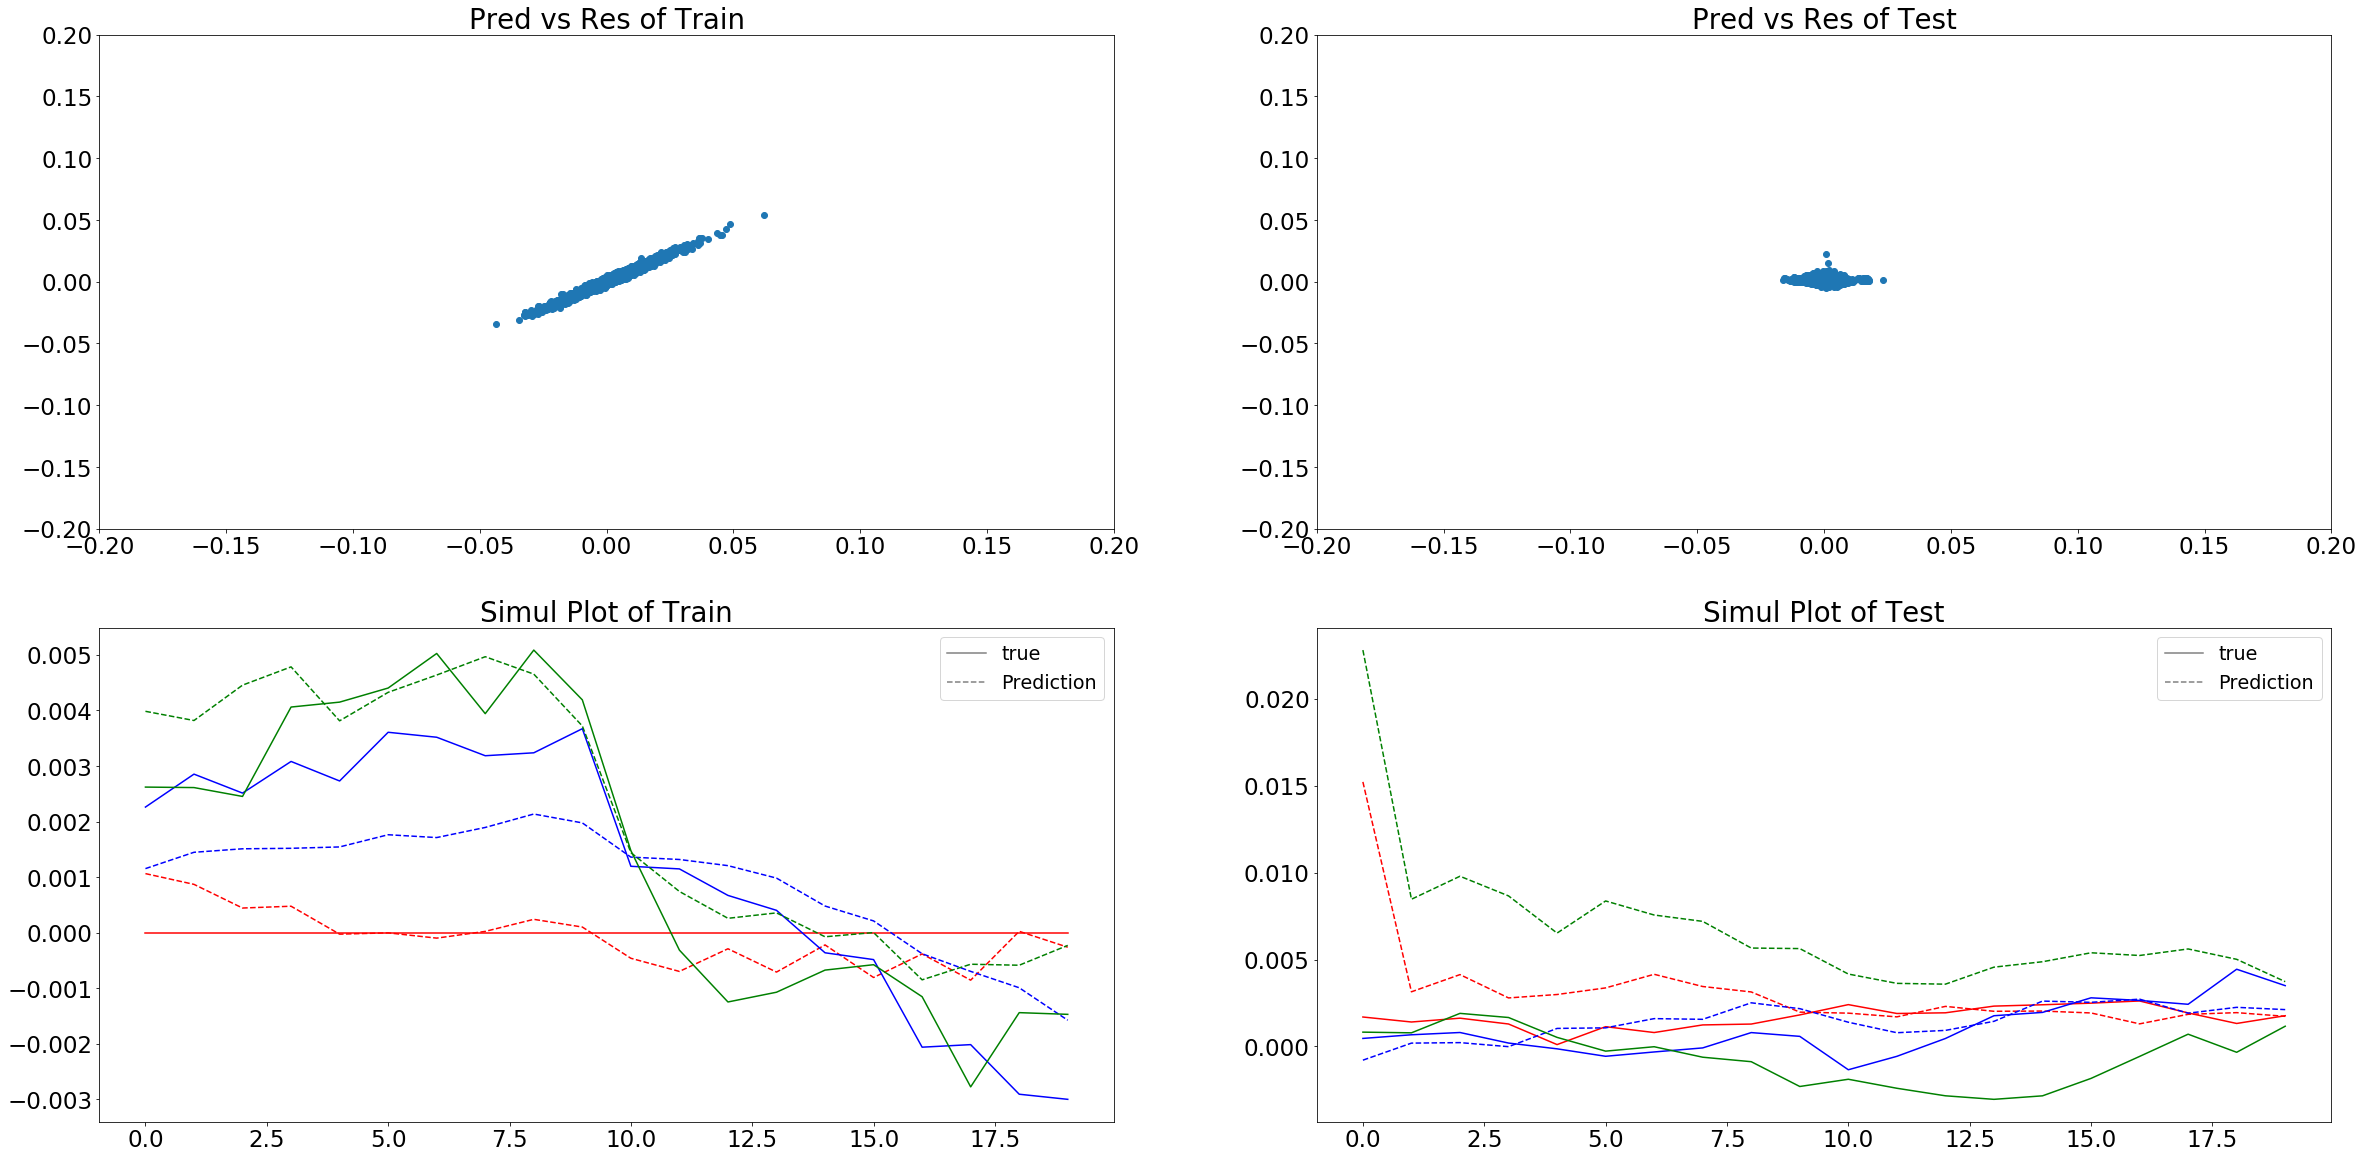

In [73]:
directional_goodness(model_cnn_2inputs, x_test_m, y_test_m)
compare_top(model_cnn_2inputs, x_test_m, y_test_m)
plots(model_cnn_2inputs, x_test=x_test_m, x_train=x_train_m, y_test=y_test_m, y_train=y_train_m)

#### Implied Volatility

In [74]:
model_cnn_2inputs,x_train_v,y_train_v,x_test_v,y_test_v = main_cnn_2inputs(returns, 100, 2000, variant='vola')
print(model_cnn_2inputs.summary())

x-train shape: (1900, 100, 20)(1900, 8, 20)
y-train shape: (1900, 20)
x-test shape: (518, 100, 20)(518, 8, 20)
y-test shape: (518, 20)
test shape: (618, 20)
0.00016486091600730117
0.00016486090316902846
0.007966318167746067
Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 100, 20)      0                                            
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 98, 64)       3904        input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 96, 64)       12352       conv1d_17[0][0]                  
_________________________________________________________________

percentage of correctly predicted directions of returns: 0.9900579150579152
Difference between mean return and return of calculated top 5: -0.0002553399492014972
(518, 20)


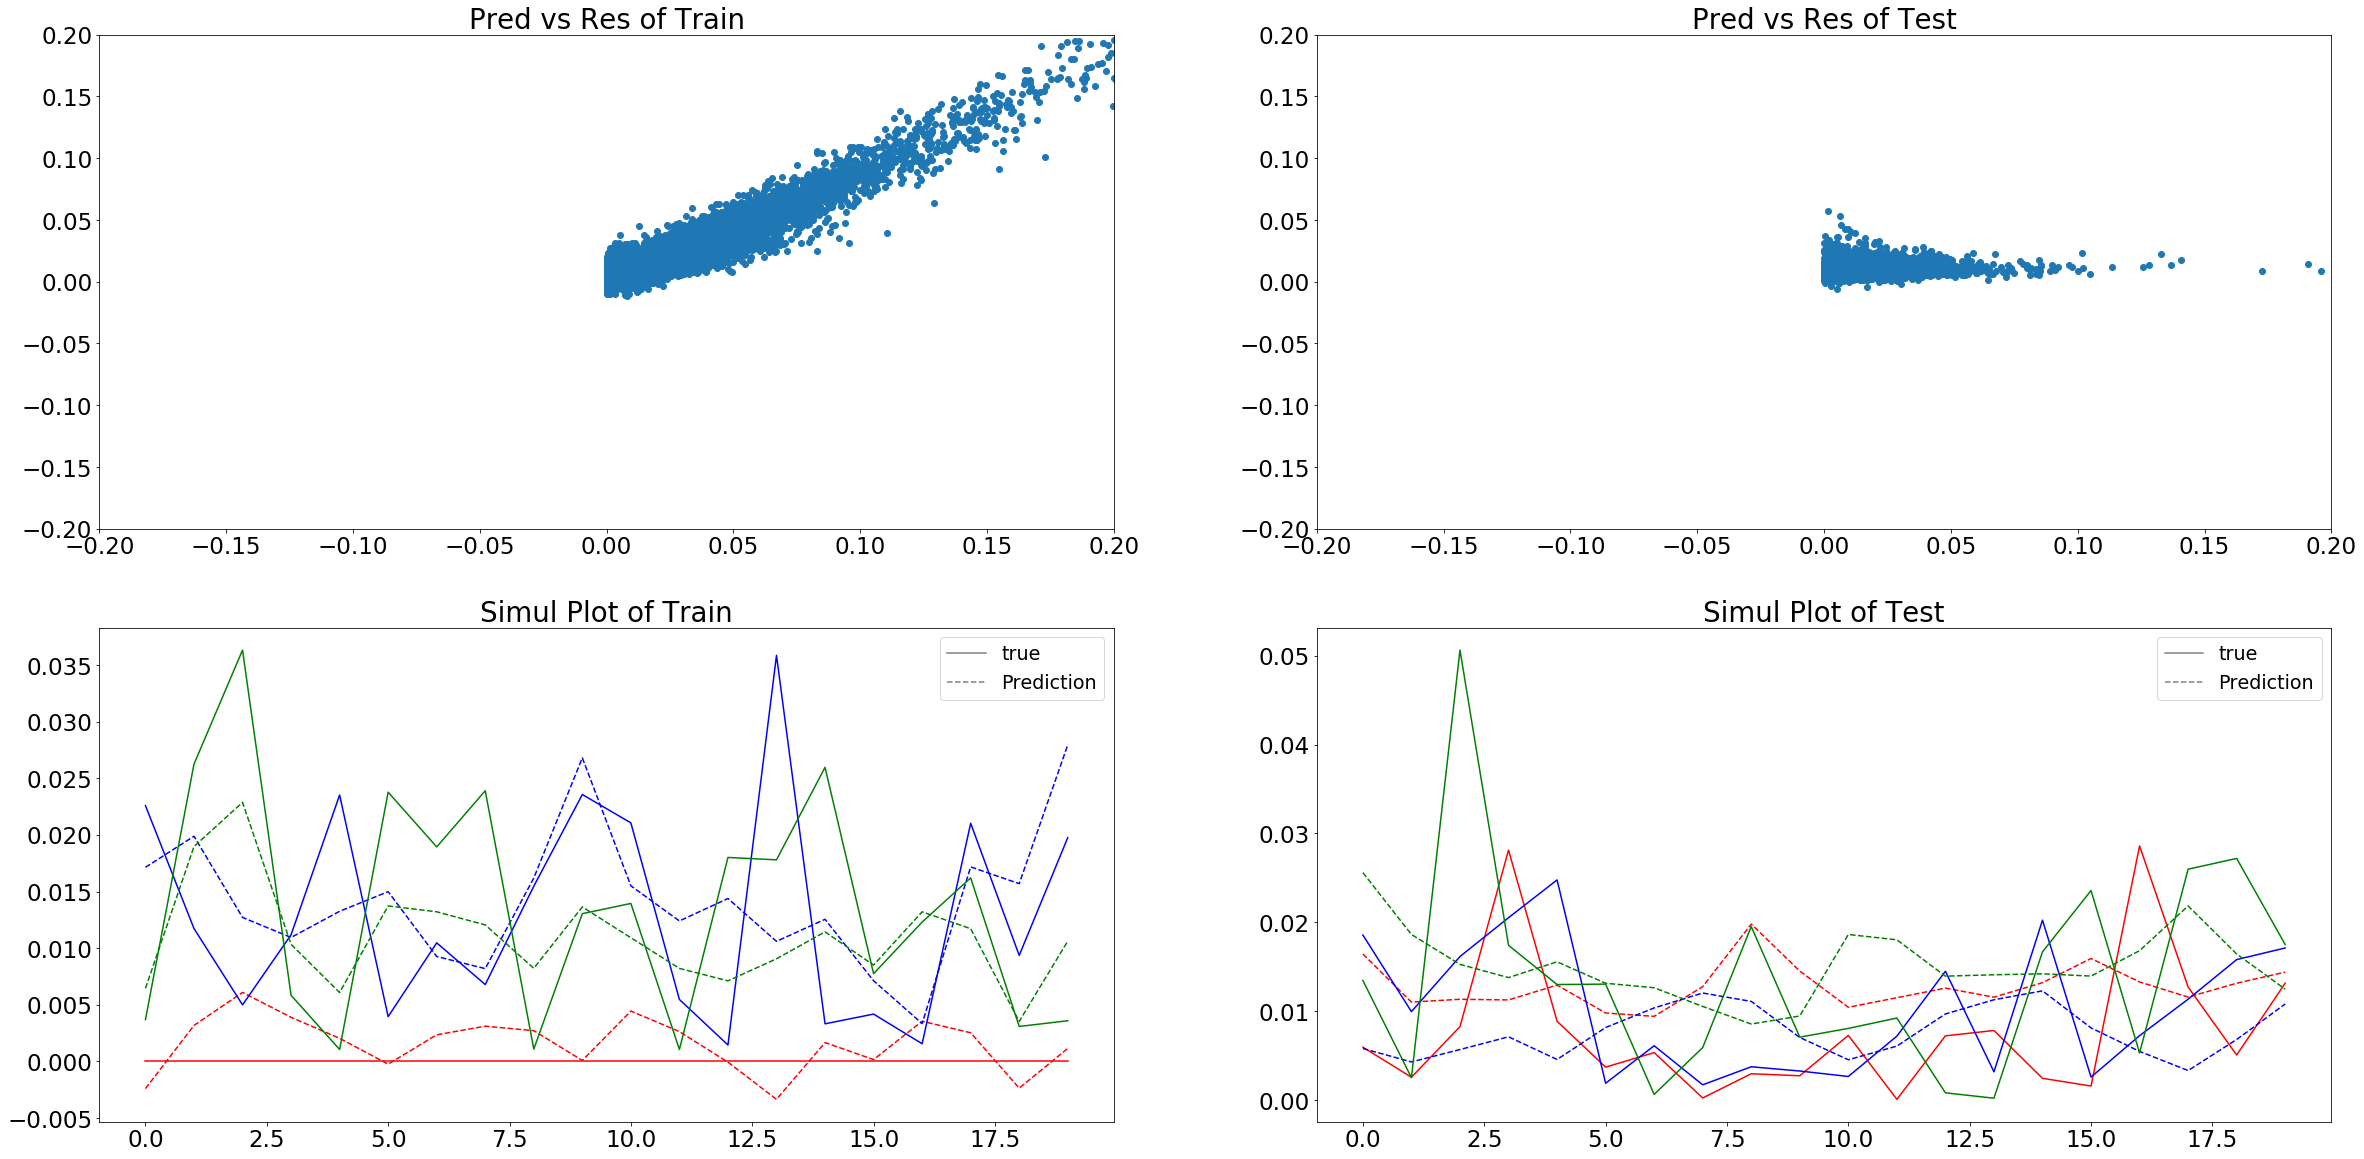

In [75]:
directional_goodness(model_cnn_2inputs, x_test_v, y_test_v)
compare_top(model_cnn_2inputs, x_test_v, y_test_v)
plots(model_cnn_2inputs, x_test=x_test_v, x_train=x_train_v, y_test=y_test_v, y_train=y_train_v)

Expectations:
- CNN with additional information of industry affiliation seems to detect known patterns of stock correlations in the same category
- This should lead to better predictions

Results: 
- Didn´t help considerably to enhance prediction power
- could be the result of overfitting due to industry labels
- Next Month Average (...)
- Volatility Input (...)

Conclusion for CNNs:
- Patterns in stocks seem to be to variable to be efficiently detected and do not contribute to effective prediction power in our calculation regime

### Fully Connected Neural Network

#### advantages:
- universal function approximator

#### disadvantages:
- prown to overfitting
- need for deep or wide hidden layers
    - trains considerably slowly

In [37]:
def fully(x_train,y_train,x_test,y_test,inp_shape):
    verbose, epochs, batch_size = 0, 100, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    N = inp_shape[1]
    #init
    model = models.Sequential()
    model.add(layers.Dense(100, activation='tanh'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(100, activation='tanh'))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(N, activation='linear'))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(x_train,y_train, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(x_test,y_test, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model
    

In [38]:
def main_fully(input_df, dur, limit, variant):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    variant     prediction of next day, next month average, volatility
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    print("now")
    x_train,y_train = get_data_subsets(train, dur, variant, onehot=0) 
    x_test,y_test = get_data_subsets(test, dur, variant, onehot=0)
    inp_shape = (x_train.shape[1],N)
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train.shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test.shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = fully(x_train, y_train, x_test, y_test, inp_shape)
    return model,x_train,y_train,x_test,y_test

#### Next Day

In [39]:
model_fully,x_train,y_train,x_test,y_test = main_fully(returns, 100, 2000, variant='next_day')
print(model_fully.summary())

now
x-train shape: (1900, 100, 20)
y-train shape: (1900, 20)
x-test shape: (518, 100, 20)
y-test shape: (518, 20)
test shape: (618, 20)
0.0003668771935676307
0.00036687718238681555
0.013366279192268848
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100, 100)          2100      
_________________________________________________________________
dense_9 (Dense)              (None, 100, 100)          10100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
dense_10 (Dense)             (None, 100, 100)          10100     
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
__________________________________________________

percentage of correctly predicted directions of returns: 0.5009652509652509
Difference between mean return and return of calculated top 5: -0.001222809974658184
(518, 20)


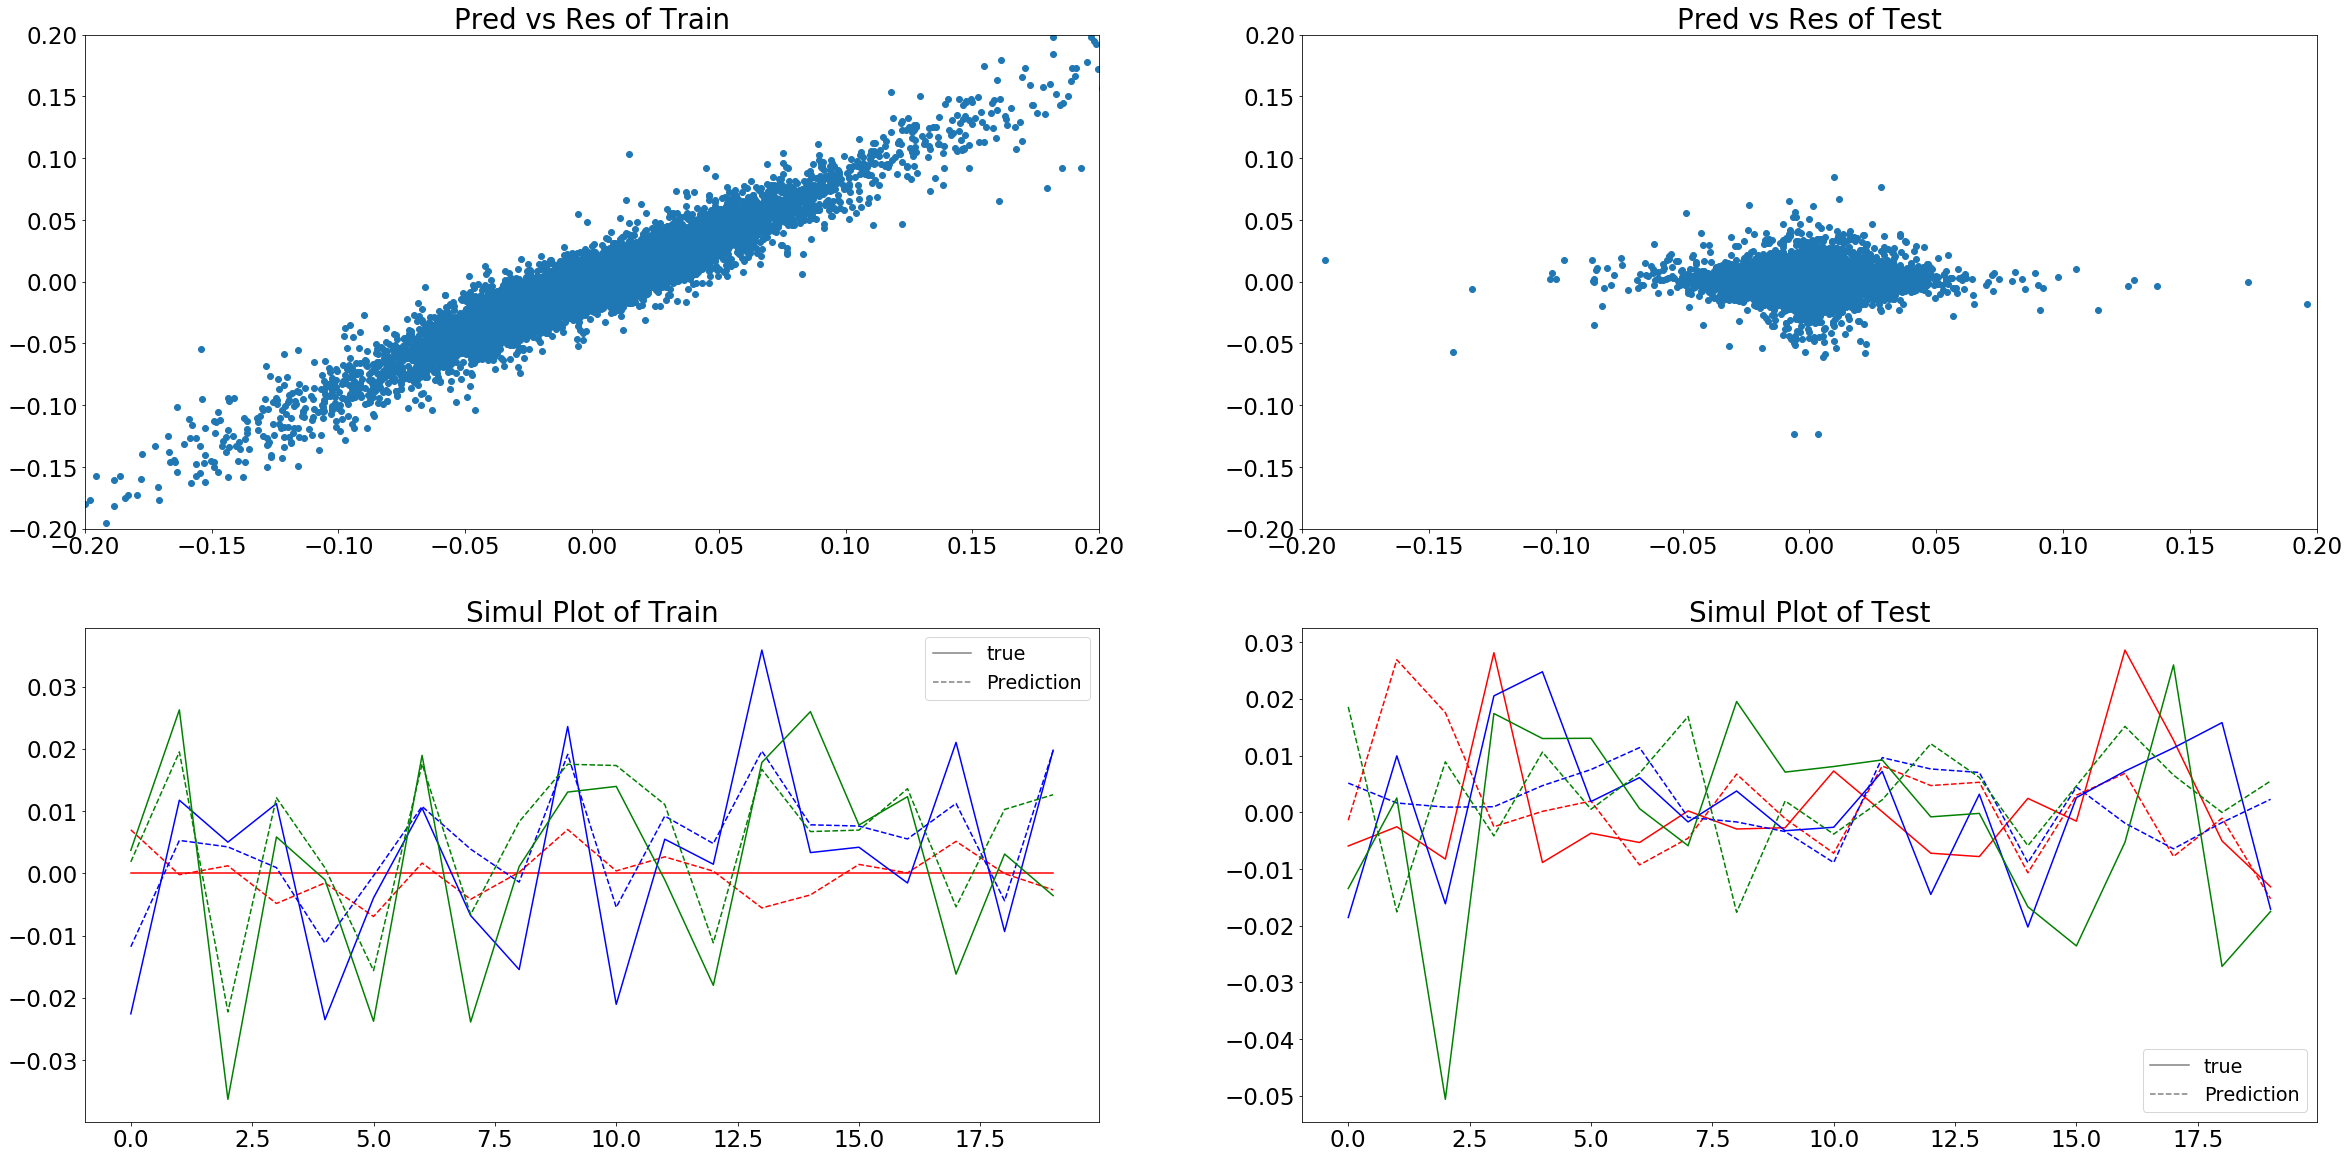

In [40]:
directional_goodness(model_fully, x_test, y_test)
compare_top(model_fully, x_test, y_test)
plots(model_fully, x_test=x_test, x_train=x_train, y_test=y_test, y_train=y_train)

####  Next Month Average

In [ ]:
model_fully,x_train_m,y_train_m,x_test_m,y_test_m = main_fully(returns, 100, 2000, variant='month')
print(model_fully.summary())

In [ ]:
directional_goodness(model_fully, x_test_m, y_test_m)
compare_top(model_fully, x_test_m, y_test_m)
plots(model_fully, x_test=x_test_m, x_train=x_train_m, y_test=y_test_m, y_train=y_train_m)

#### Implied Volatility

In [ ]:
model_fully,x_train_v,y_train_v,x_test_v,y_test_v = main_fully(returns, 100, 2000, variant='vola')
print(model_fully.summary())

In [ ]:
directional_goodness(model_fully, x_test_v, y_test_v)
compare_top(model_fully, x_test_v, y_test_v)
plots(model_fully, x_test=x_test_v, x_train=x_train_v, y_test=y_test_v, y_train=y_train_v)

Expectations:
- The fully connected Neural Network can fit "theoretically everything"
- limited Prediction Power since unspecialised

Results:
- trains slowly
- prediction power subpar

### Recurrent Neural Network with Gated Recurrent Units

#### advantages:
- optimized for Time Series Predictions
- Input Length not fixed

#### disadvantages:
- trains considerably slowly

In [42]:
def gru(x_train, y_train, x_test, y_test, inp_shape):
    verbose, epochs, batch_size = 0, 200, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    N = inp_shape[1]
    #init
    model = models.Sequential()
    model.add(layers.GRU(42, input_shape = inp_shape, return_sequences = True))
    model.add(layers.Dropout(0.2))
    model.add(layers.GRU(42, return_sequences = False))
    
    #Dropout sets randomly chosen values to 0 to prevent overfitting
    
    #model.add(layers.MaxPooling1D(pool_size=2))
    #MaxPooling halbiert array Größe und nimmt größte Werte der Feature-Gewichtungen 
    
    #model.add(layers.Flatten())
    #Flatten reduziert dimensionen eines arrays auf niedrigst mögliche Dimension (1xdim) (überschreibt Nullen))
    
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(N, activation='linear'))
    #Klassisches NN hinter Convolutional Layer geschaltet, lernt also im Feature Raum, durch Convolutional Net     vorgebenen
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(x_train,y_train, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(x_test,y_test, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model


In [43]:
def main_gru(input_df, dur, limit, variant):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    variant     prediction of next day, next month average, volatility
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur, variant, onehot=0) 
    x_test,y_test = get_data_subsets(test, dur, variant, onehot=0)
    inp_shape = (dur,N)
    
    x_train = x_train[:,x_train.shape[1]-dur:,:]
    x_test = x_test[:,x_test.shape[1]-dur:,:]
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train.shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test.shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = gru(x_train, y_train, x_test, y_test, inp_shape)
    return model,x_train,y_train,x_test,y_test

#### Next Day

In [44]:
model_gru,x_train,y_train,x_test,y_test = main_gru(returns, 100, 2000, variant='next_day')
print(model_gru.summary())

x-train shape: (1900, 100, 20)
y-train shape: (1900, 20)
x-test shape: (518, 100, 20)
y-test shape: (518, 20)
test shape: (618, 20)
0.0002945321110328012
0.0002945321029983461
0.011628104373812675
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 100, 42)           7938      
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 42)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 42)                10710     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               4300      
_________________________________________________________________
dense_14 (Dense)             (None, 20)                2020      
Total params: 24,968
Trainable params: 24,968
Non-train

percentage of correctly predicted directions of returns: 0.5004826254826255
Difference between mean return and return of calculated top 5: 0.004342980312624249
(518, 20)


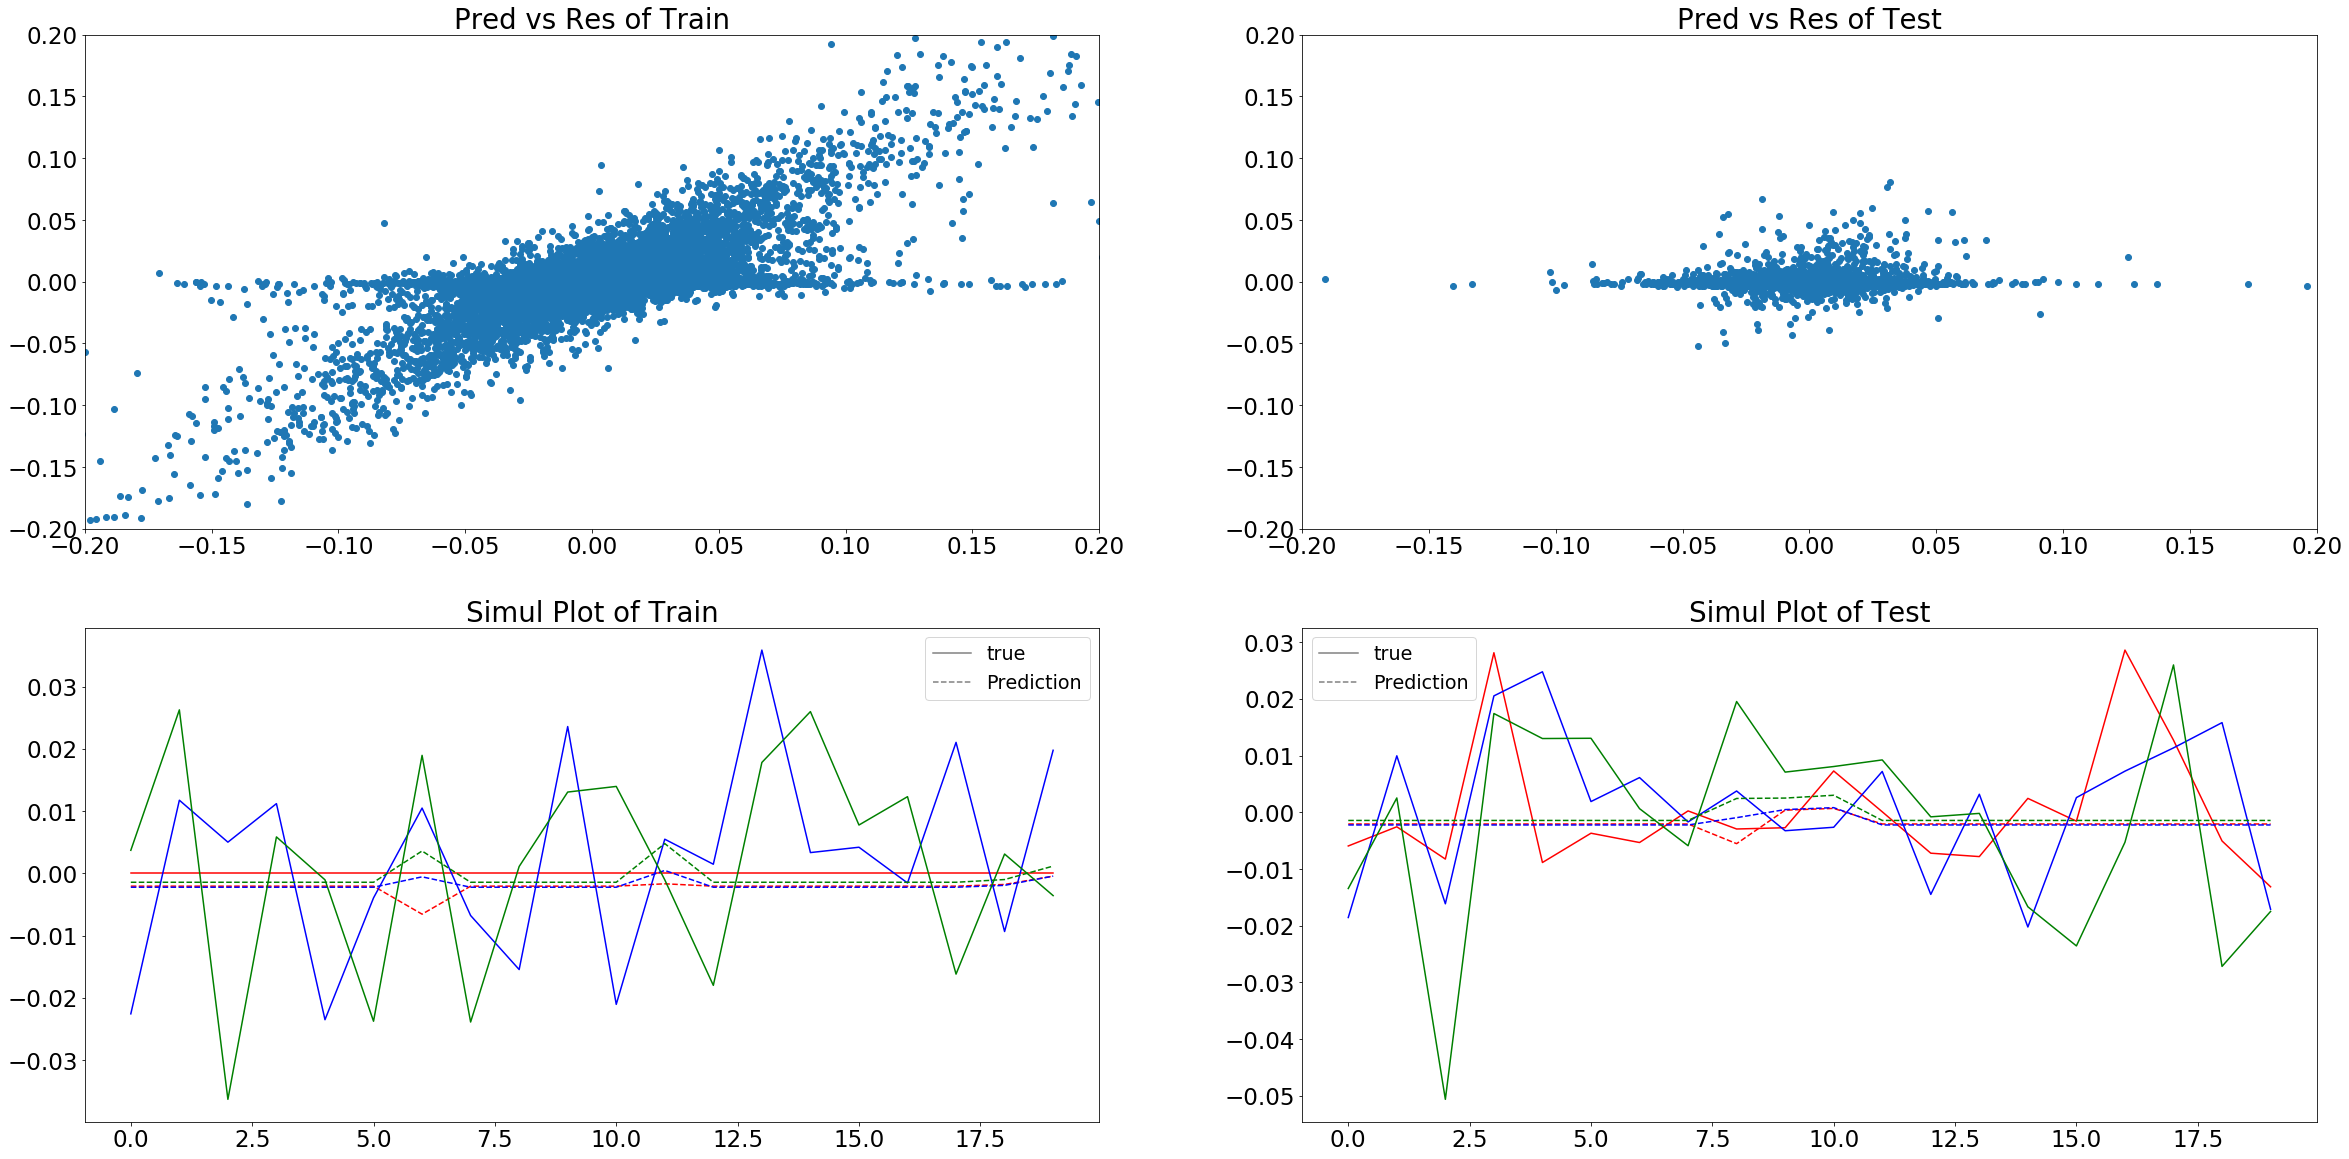

In [45]:
directional_goodness(model_gru, x_test, y_test)
compare_top(model_gru, x_test, y_test)
plots(model_gru, x_test=x_test, x_train=x_train, y_test=y_test, y_train=y_train)

#### Next Month Average

In [ ]:
model_gru,x_train_m,y_train_m,x_test_m,y_test_m = main_gru(returns, 100, 2000, variant='month')
print(model_gru.summary())

In [ ]:
directional_goodness(model_gru, x_test_m, y_test_m)
compare_top(model_gru, x_test_m, y_test_m)
plots(model_gru, x_test=x_test_m, x_train=x_train_m, y_test=y_test_m, y_train=y_train_m)

#### Implied Volatility

In [ ]:
model_gru,x_train_v,y_train_v,x_test_v,y_test_v = main_gru(returns, 100, 2000, variant='next_day')
print(model_gru.summary())

In [ ]:
directional_goodness(model_gru, x_test, y_test)
compare_top(model_gru, x_test_v, y_test_v)
plots(model_gru, x_test=x_test_v, x_train=x_train_v, y_test=y_test_v, y_train=y_train_v)

Expectations:
- RNN fits stock market data good, specialised on time series prediction
- GRU learns faster but less effective
- Choice of hyperparameters essential

Results:
- Seriously underfits Changes
- Close to Moving Average

### Recurrent Neural Network with One-Hot Encoded Branch Info

#### Advantages:
- Network does not have to learn Known Correlations

#### Disadvantages:
- More complicated Data Structure
- Need to build non Sequential Network
    - One for Adjusted Close
    - One for Industry Sectors

In [47]:
def gru_2inputs(xtrain,ytrain,xtest,ytest,inp_shape1,inp_shape2):
    verbose, epochs, batch_size = 0, 200, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    i1 = layers.Input(inp_shape1)
    i2 = layers.Input(inp_shape2)
    
    N = inp_shape1[1]
    #init
    model1 = layers.GRU(100, input_shape = inp_shape1, return_sequences = True)(i1)
    model1 = layers.Dropout(0.2)(model1)
    model1 = layers.GRU(100, return_sequences = False)(model1)
    #relu = 0 für value<0 sonst linear
    
    
    
    #model1 = layers.Flatten()(model1)
    #Flatten reduziert dimensionen eines arrays auf niedrigst mögliche Dimension (1xdim) (überschreibt Nullen))
    model1 = models.Model(inputs = i1, outputs = model1)
    
    
    ### second network:
    model2 = layers.Flatten()(i2)
    model2 = layers.Dense(100, activation="relu")(model2)
    #model2 = layers.Dropout(0.01)(model2)
    #model2 = layers.Dense(100, activation="relu")(model2)
    model2 = models.Model(inputs = i2, outputs = model2)
    
    combined = layers.concatenate([model1.output, model2.output])
    
    
    model = layers.Dense(100, activation='relu')(combined)
    model = layers.Dense(N, activation='linear')(model)
    model = models.Model(inputs = [model1.input, model2.input], outputs = model)
    #Klassisches NN hinter Convolutional Layer geschaltet, lernt also im Feature Raum, durch Convolutional Net          vorgebenen
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(xtrain,ytrain, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(xtest,ytest, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model

In [48]:
def main_gru_2inputs(input_df, dur, limit, variant):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur, variant, onehot=1) 
    x_test,y_test = get_data_subsets(test, dur, variant, onehot=1)
    inp_shape1 = (dur,N)
    inp_shape2 = (x_train.shape[1]-dur,N)
    x_train = [x_train[:,inp_shape2[0]:,:],x_train[:,:inp_shape2[0],:]]
    x_test = [x_test[:,inp_shape2[0]:,:],x_test[:,:inp_shape2[0],:]]
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train[0].shape)+ str(x_train[1].shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test[0].shape)+ str(x_test[1].shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = gru_2inputs(x_train, y_train, x_test, y_test, inp_shape1,inp_shape2)
    return model,x_train,y_train,x_test,y_test

#### Next Day

In [49]:
model_gru_2inputs,x_train,y_train,x_test,y_test = main_gru_2inputs(returns, 100, 2000, variant='next_day')
print(model_gru_2inputs.summary())

x-train shape: (1900, 100, 20)(1900, 8, 20)
y-train shape: (1900, 20)
x-test shape: (518, 100, 20)(518, 8, 20)
y-test shape: (518, 20)
test shape: (618, 20)
0.0003312900138216122
0.0003312900080345571
0.012371761724352837
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100, 20)      0                                            
__________________________________________________________________________________________________
gru_3 (GRU)                     (None, 100, 100)     36300       input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 8, 20)        0                                            
____________________________________________________________________

percentage of correctly predicted directions of returns: 0.5061776061776062
Difference between mean return and return of calculated top 5: -0.001990746459872147
(518, 20)


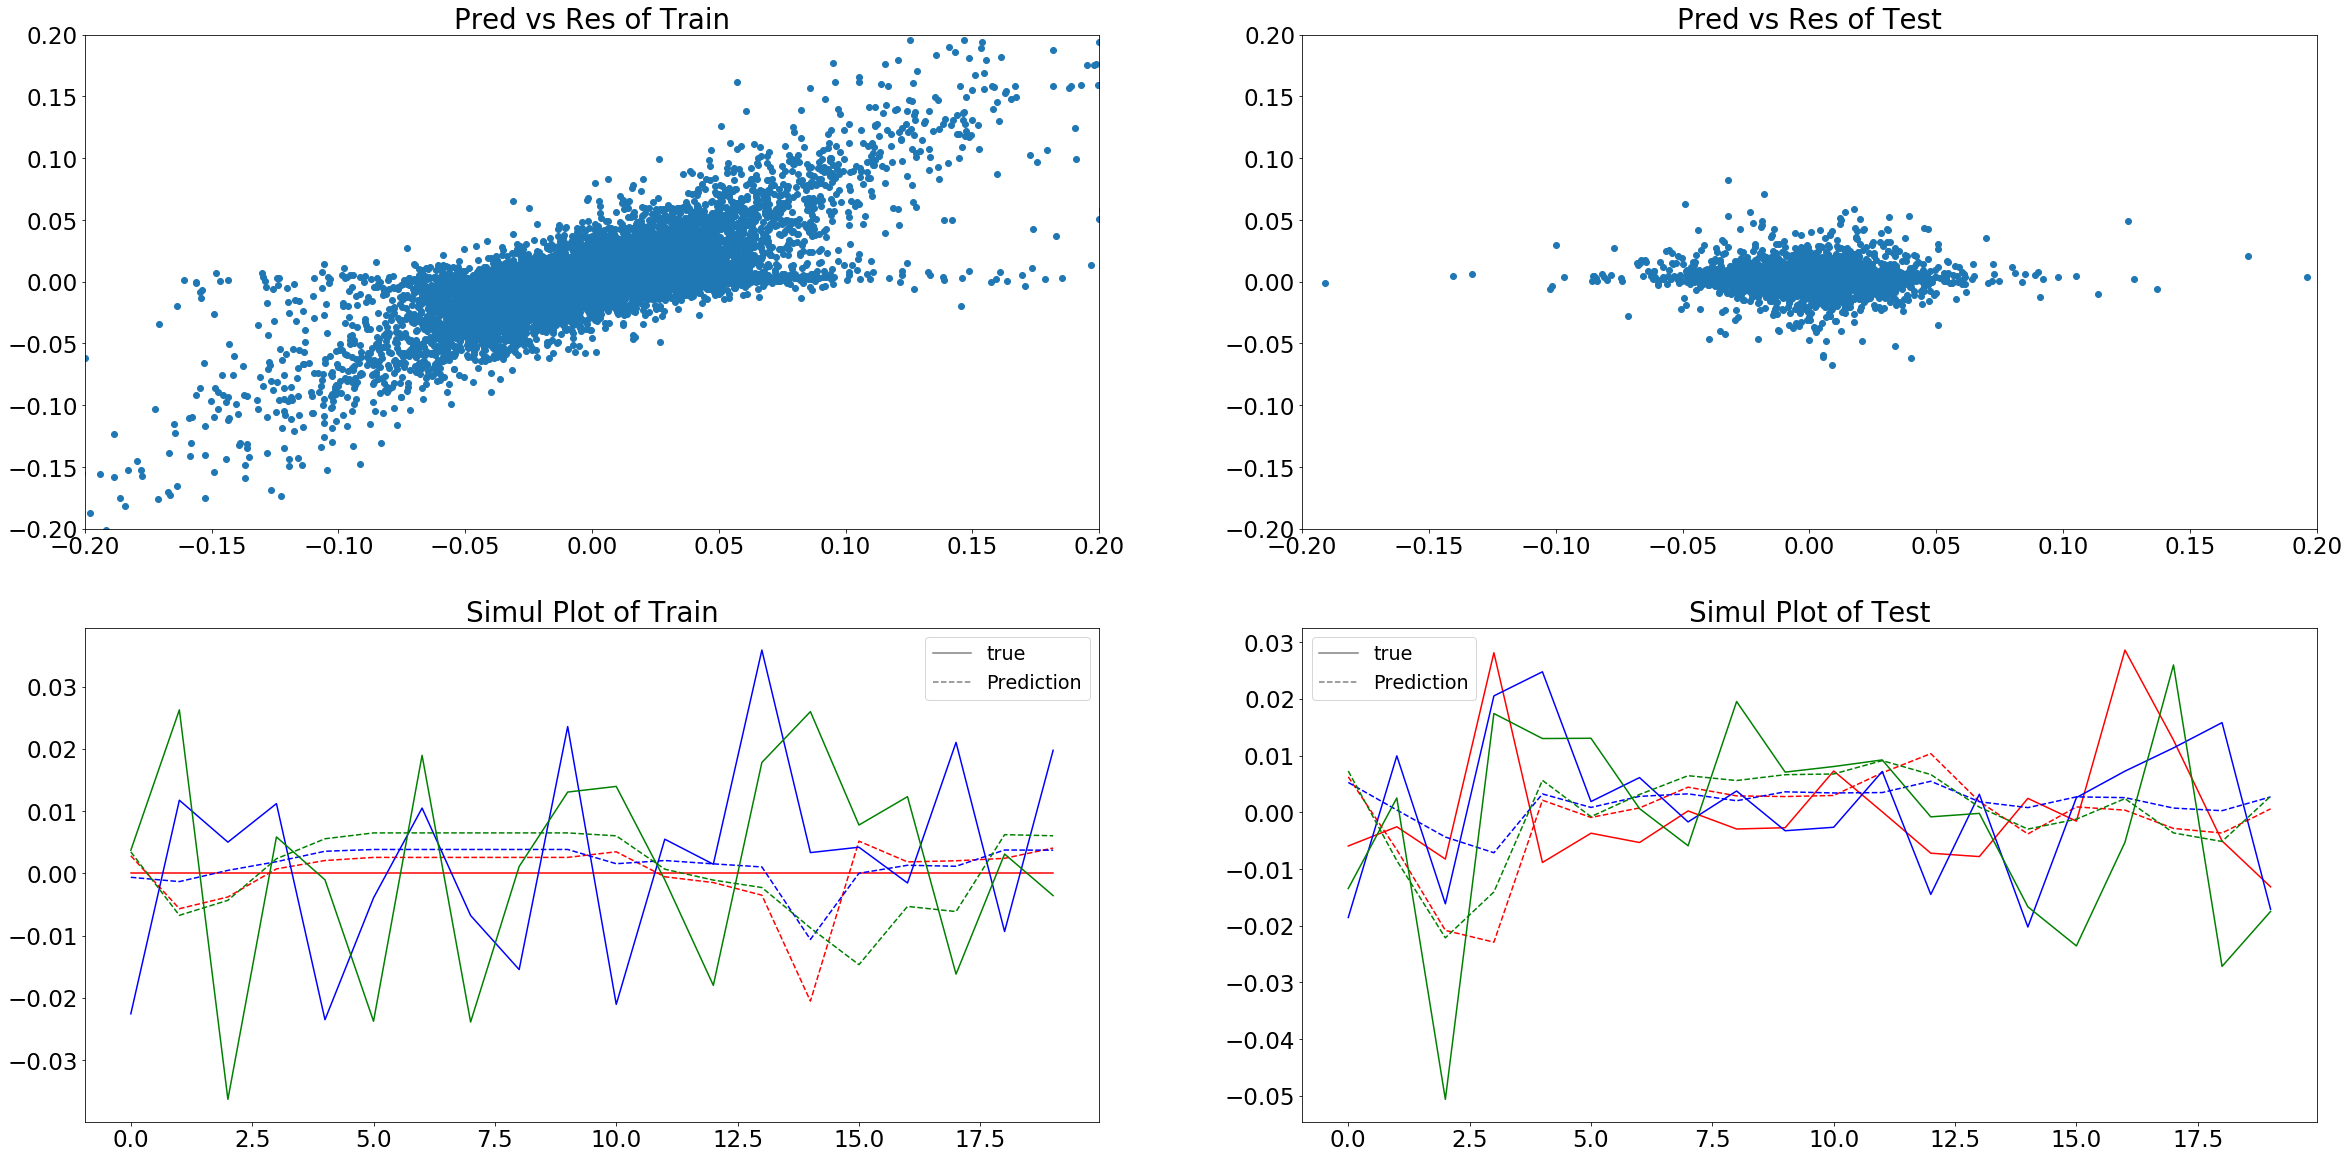

In [50]:
directional_goodness(model_gru_2inputs, x_test, y_test)
compare_top(model_gru_2inputs, x_test, y_test)
plots(model_gru_2inputs, x_test=x_test, x_train=x_train, y_test=y_test, y_train=y_train)

#### Next Month Average

In [ ]:
model_gru_2inputs,x_train_m,y_train_m,x_test_m,y_test_m = main_gru_2inputs(returns, 100, 2000, variant='month')
print(model_gru_2inputs.summary())

x-train shape: (1900, 100, 20)(1900, 8, 20)
y-train shape: (1900, 20)
x-test shape: (518, 100, 20)(518, 8, 20)
y-test shape: (518, 20)
test shape: (618, 20)


In [ ]:
directional_goodness(model_gru_2inputs, x_test_m, y_test_m)
compare_top(model_gru_2inputs, x_test_m, y_test_m)
plots(model_gru_2inputs, x_test=x_test_m, x_train=x_train_m, y_test=y_test_m, y_train=y_train_m)

#### Implied Volatility

In [ ]:
model_gru_2inputs,x_train_v,y_train_v,x_test_v,y_test_v = main_gru_2inputs(returns, 100, 2000, variant='vola')
print(model_gru_2inputs.summary())

In [ ]:
directional_goodness(model_gru_2inputs, x_test_v, y_test_v)
compare_top(model_gru_2inputs, x_test_v, y_test_v)
plots(model_gru_2inputs, x_test=x_test_v, x_train=x_train_v, y_test=y_test_v, y_train=y_train_v)

Expectations:
- Additional Industry information adds underlying structure
- Fits become better than regular GRU RNN

Results: 
- Seriously underfits Stock Data

### Recurrent Neural Network with Long Short-Term Memory

#### Advantages:
- Performs slightly better than GRU

#### Disadvantages:
- Trains slow

### Rule of thumb for Number of Hidden Nodes

$$n_h \approx {2(n_i + n_o) \over 3}$$

$n_i$ number of stocks  

$n_o$ number of days 

In [53]:
def lstm(x_train, y_train, x_test, y_test, inp_shape):
    verbose, epochs, batch_size = 0, 200, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    N = inp_shape[1]
    D = inp_shape[0]
    
    hidden = int(2/3*(N+D))
    
    #init
    model = models.Sequential()
    model.add(layers.LSTM(90, input_shape = inp_shape, return_sequences = True))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(90, return_sequences = False))
    
    #Dropout sets randomly chosen values to 0 to prevent overfitting
    
    #model.add(layers.MaxPooling1D(pool_size=2))
    #MaxPooling halbiert array Größe und nimmt größte Werte der Feature-Gewichtungen 
    
    #model.add(layers.Flatten())
    #Flatten reduziert dimensionen eines arrays auf niedrigst mögliche Dimension (1xdim) (überschreibt Nullen))
    
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(N, activation='linear'))
    #Klassisches NN hinter Convolutional Layer geschaltet, lernt also im Feature Raum, durch Convolutional Net vorgebenen
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
            #fit network
    model.fit(x_train,y_train, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(x_test,y_test, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model

In [54]:
def main_lstm(input_df, dur, limit, variant):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur, variant, onehot=0) 
    x_test,y_test = get_data_subsets(test, dur, variant, onehot=0)
    inp_shape = (x_train.shape[1],N)
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train.shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test.shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = lstm(x_train, y_train, x_test, y_test, inp_shape)
    return model,x_train,y_train,x_test,y_test

#### Next Day

In [55]:
model_lstm,x_train,y_train,x_test,y_test = main_lstm(returns, 100, 2000, variant='next_day')
print(model_lstm.summary())

x-train shape: (1900, 100, 20)
y-train shape: (1900, 20)
x-test shape: (518, 100, 20)
y-test shape: (518, 20)
test shape: (618, 20)
0.0002907651130911898
0.0002907651069108397
0.011595610529184341
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 90)           39960     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 90)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90)                65160     
_________________________________________________________________
dense_18 (Dense)             (None, 100)               9100      
_________________________________________________________________
dense_19 (Dense)             (None, 20)                2020      
Total params: 116,240
Trainable params: 116,240
Non-tra

percentage of correctly predicted directions of returns: 0.5053088803088803
Difference between mean return and return of calculated top 5: 0.00018864899656601377
(518, 20)


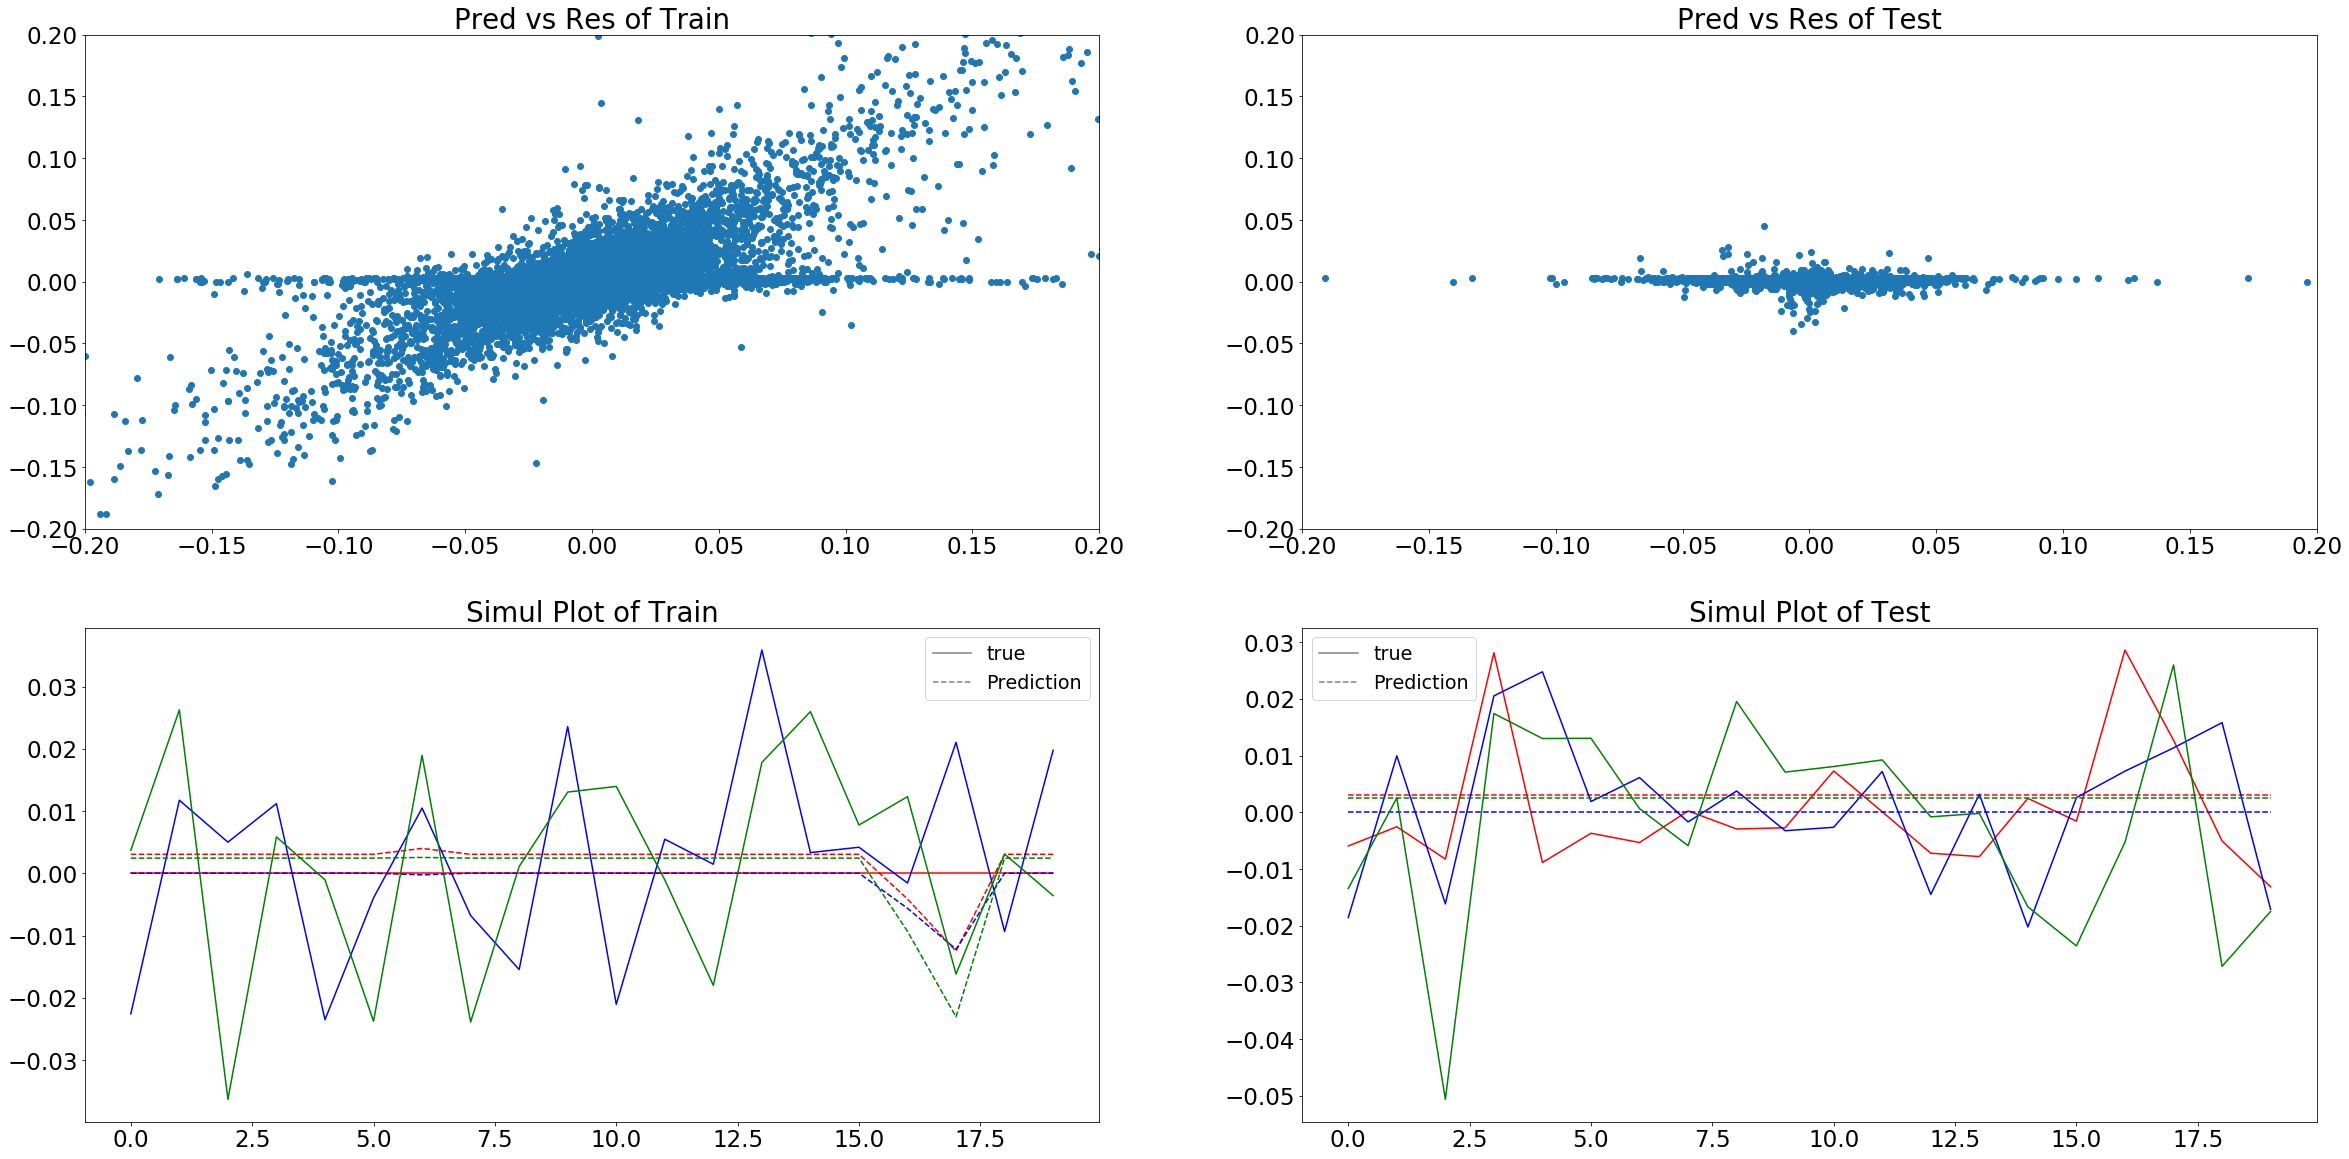

In [56]:
directional_goodness(model_lstm, x_test, y_test)
compare_top(model_lstm, x_test, y_test)
plots(model_lstm, x_test=x_test, x_train=x_train, y_test=y_test, y_train=y_train)

#### Next Month Average

In [ ]:
model_lstm,x_train_m,y_train_m,x_test_m,y_test_m = main_lstm(returns, 100, 2000, variant='month')
print(model_lstm.summary())

In [ ]:
directional_goodness(model_lstm, x_test_m, y_test_m)
compare_top(model_lstm, x_test_m, y_test_m)
plots(model_lstm, x_test=x_test_m, x_train=x_train_m, y_test=y_test_m, y_train=y_train_m)

#### Implied Volatility

In [ ]:
model_lstm,x_train_v,y_train_v,x_test_v,y_test_v = main_lstm(returns, 100, 2000, variant='vola')
print(model_lstm.summary())

In [ ]:
directional_goodness(model_lstm, x_test_v, y_test_v)
compare_top(model_lstm, x_test_v, y_test_v)
plots(model_lstm, x_test=x_test_v, x_train=x_train_v, y_test=y_test_v, y_train=y_train_v)

Expectations:
- Long-Short Term Memory RNN will learn slower than regular RNN
- Should learn underlying time-series structure better than GRU RNN

Results:
- Like GRU does underestimate return values

### LSTM with One-Hot Encoded Information

#### advantages:
- network does not have to learn known correlations

#### disadvantages:
- more complicated data structure
- need to build non sequential network
    - one for adjusted close
    - one for industry sectors

In [57]:
def lstm_2inputs(xtrain,ytrain,xtest,ytest,inp_shape1,inp_shape2):
    verbose, epochs, batch_size = 0, 200, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    i1 = layers.Input(inp_shape1)
    i2 = layers.Input(inp_shape2)
    
    N = inp_shape1[1]
    #init
    model1 = layers.LSTM(90, input_shape = inp_shape1, return_sequences = True)(i1)
    model1 = layers.Dropout(0.2)(model1)
    model1 = layers.LSTM(90, return_sequences = False)(model1)
    #relu = 0 für value<0 sonst linear
    
    
    
    #model1 = layers.Flatten()(model1)
    #Flatten reduziert dimensionen eines arrays auf niedrigst mögliche Dimension (1xdim) (überschreibt Nullen))
    model1 = models.Model(inputs = i1, outputs = model1)
    
    
    ### second network:
    model2 = layers.Flatten()(i2)
    model2 = layers.Dense(100, activation="relu")(model2)
    #model2 = layers.Dropout(0.01)(model2)
    #model2 = layers.Dense(100, activation="relu")(model2)
    model2 = models.Model(inputs = i2, outputs = model2)
    
    combined = layers.concatenate([model1.output, model2.output])
    
    
    model = layers.Dense(100, activation='relu')(combined)
    model = layers.Dense(N, activation='linear')(model)
    model = models.Model(inputs = [model1.input, model2.input], outputs = model)
    #Klassisches NN hinter Convolutional Layer geschaltet, lernt also im Feature Raum, durch Convolutional Net vorgebenen
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    model.fit(xtrain,ytrain, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(xtest,ytest, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model

In [58]:
def main_lstm_2inputs(input_df, dur, limit, variant):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    """

    N = input_df.shape[1]
    D = input_df.shape[0]
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur, variant, onehot=1) 
    x_test,y_test = get_data_subsets(test, dur, variant, onehot=1)
    inp_shape1 = (dur,N)
    inp_shape2 = (x_train.shape[1]-dur,N)
    x_train = [x_train[:,inp_shape2[0]:,:],x_train[:,:inp_shape2[0],:]]
    x_test = [x_test[:,inp_shape2[0]:,:],x_test[:,:inp_shape2[0],:]]
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train[0].shape)+ str(x_train[1].shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test[0].shape)+ str(x_test[1].shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
    
    model = lstm_2inputs(x_train, y_train, x_test, y_test, inp_shape1,inp_shape2)
    return model,x_train,y_train,x_test,y_test

#### Next Day

In [59]:
model_lstm_2inputs,x_train,y_train,x_test,y_test = main_lstm_2inputs(returns, 100, 2000, variant='next_day')
print(model_lstm_2inputs.summary())

x-train shape: (1900, 100, 20)(1900, 8, 20)
y-train shape: (1900, 20)
x-test shape: (518, 100, 20)(518, 8, 20)
y-test shape: (518, 20)
test shape: (618, 20)
0.00031838330379992894
0.00031838330323807895
0.012145080603659153
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100, 20)      0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 100, 90)      39960       input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 8, 20)        0                                            
__________________________________________________________________

percentage of correctly predicted directions of returns: 0.4937258687258687
Difference between mean return and return of calculated top 5: -0.0003907617662139006
(518, 20)


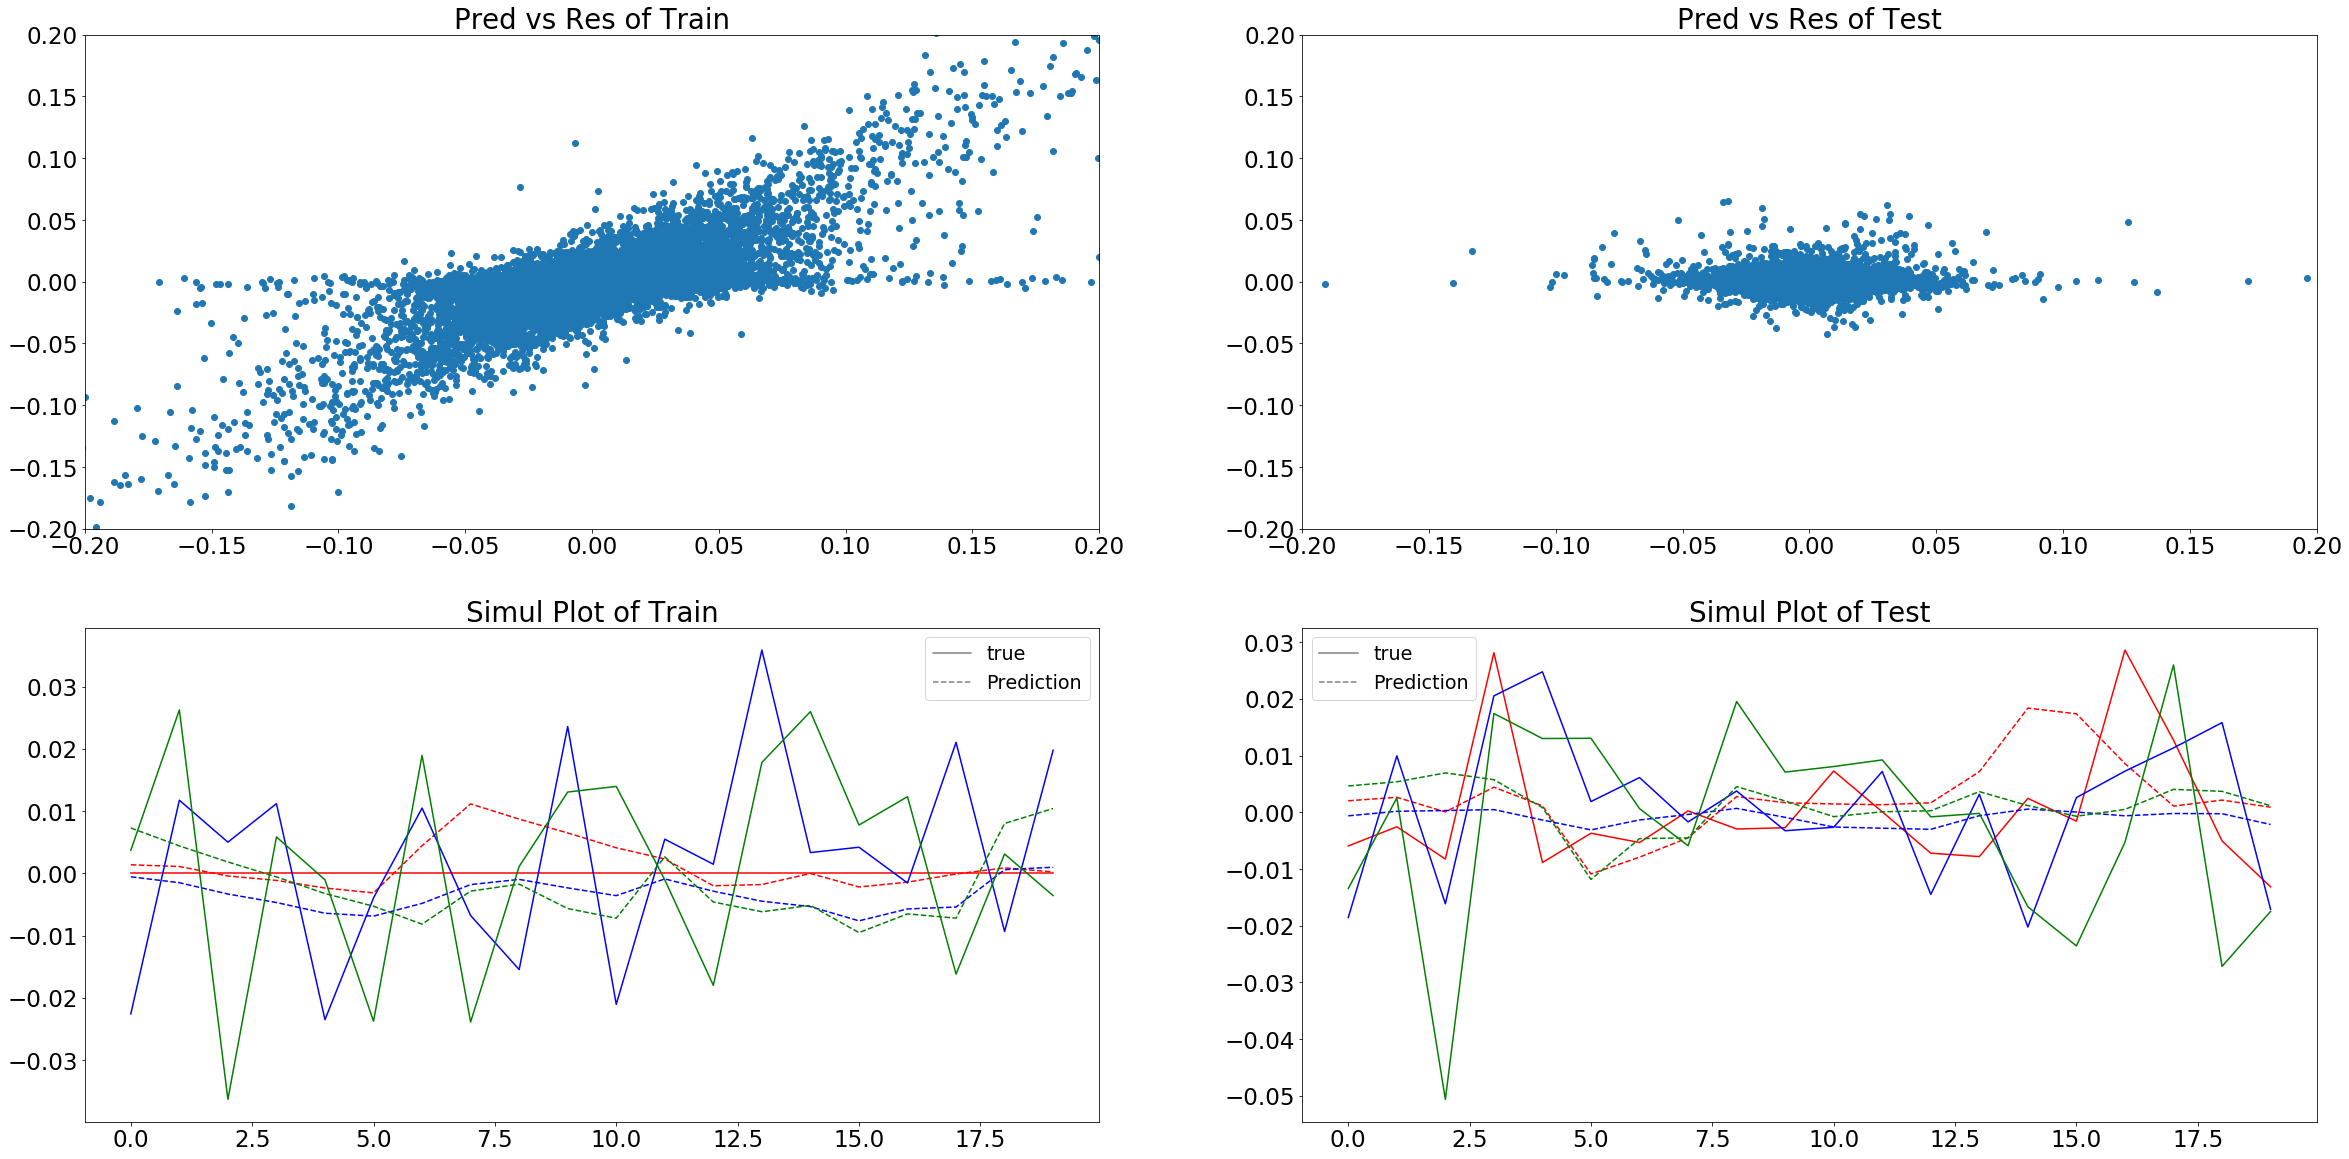

In [60]:
directional_goodness(model_lstm_2inputs, x_test, y_test)
compare_top(model_lstm_2inputs, x_test, y_test)
plots(model_lstm_2inputs, x_test=x_test, x_train=x_train, y_test=y_test, y_train=y_train)

#### Next Month Average

In [ ]:
model_lstm_2inputs,x_train_m,y_train_m,x_test_m,y_test_m = main_lstm_2inputs(returns, 100, 2000, variant='next_day')
print(model_lstm_2inputs.summary())

In [ ]:
directional_goodness(model_lstm_2inputs, x_test_m, y_test_m)
compare_top(model_lstm_2inputs, x_test_m, y_test_m)
plots(model_lstm_2inputs, x_test=x_test_m, x_train=x_train_m, y_test=y_test_m, y_train=y_train_m)

#### Implied Volatility

In [ ]:
model_lstm_2inputs,x_train_v,y_train_v,x_test_v,y_test_v = main_lstm_2inputs(returns, 100, 2000, variant='next_day')
print(model_lstm_2inputs.summary())

In [ ]:
directional_goodness(model_lstm_2inputs, x_test_v, y_test_v)
compare_top(model_lstm_2inputs, x_test_v, y_test_v)
plots(model_lstm_2inputs, x_test=x_test_v, x_train=x_train_v, y_test=y_test_v, y_train=y_train_v)

## Discussion and Outlook


- Neural Networks don´t really do a good job on predicting stock markets
- Patterns are too variable to be recognised as patterns by machines
- time series prediction works ok

- Input Data Transformations can be optimized, so that maybe structure is recognizable 
    - smoothing, space transformation, clustering, etc
- Neural Networks can be optimized
    - hyperparameters are of the essence with most NNs
    - input shape (time window, stock number)
    - number of different kinds of neurons, layers, etc.
    - activation functions
    - 
- More computational power could help
    - sometimes NNs have a "breakthrough" in learning curve after what seems like convergence
- One-Hot Encoded Information of Industry sectors usually improves prediction power
    - Firms Evidence that Underlying Industry Sector Information is relevant